# Кинетика социального неравенства

![](https://drive.google.com/uc?export=view&id=1vtzMpzMkJyCKOsAO6njDQeIB_6CoSasx)

## Моделирование процесса с точки зрения кода
Моделирование процесса производится с помощью языка Python. Основные классы - Человек(Person) и Популяция(Population).

1. **Person** - класс человека. У каждого экземпляра имеется уникальный идентификационный номер и некоторая сумма наличности. Во избежании утечек денег при обменах реализованы методы получения текущего значения наличности, передачи ставки, принятия наличности, а также метод уплаты налогов.
* *получение значения наличности(get_money)* - возвращает текущее значение наличности данного человека.
* *передача ставки(make_bet)* - в случае, если человеку хватает денег для того, чтобы сделать ставку - делает ставку в стандартном режиме, уменьшая свое состояние на размер ставки и возвращая её. Если деньги есть, но их не хватает для полной ставки - ставит все свои деньги, обнуляя свой баланс. Если денег нет, то возвращает нулевую ставку.
* *уплата налогов(pay_taxes)* - процесс аналогичный передачи ставки, однако вместо размера ставки высчитывается налоговый вычет, составляющий указанную часть капитала человека.
* *получение денег(get_money)* - прибавляет к своему балансу указанное количество денег. Это может быть налог, выплаченный государством или выигрыш в розыгрыше с другим человеком.
2. **Population** - класс популяции из людей. Мы считаем популяцию закрытой в том плане, что общая сумма денег популяции сохраняется.   

Атрибуты класса:
* *loss* - используемая функция потерь при расчете расхождения с теоретической кривой распределения богатства. Можно выбрать L1 или L2.
* *multiprocessing_enable* - включение многопотоковой обработки. К сожалению, в поставленных экспериментах число людей недостаточно большое для увеличения эффективности расчетов. Возможно при дальнейшем увеличении числа людей ускорение будет более ощутимо, однако каждый эксперимент будет рассчитываться слишком долго. Сравнительная таблица времени(в секундах) работы 100 эпох расчета приведена ниже
![](https://drive.google.com/uc?export=view&id=1fzqL1GYe3gShosI16ENf450HiZz7-eOK)
* *money_stratification* - исходное распределение денег. Если целочисленное значение, то каждый человек в популяции получает эту сумму. Если словарь формата {число_денег : кол-во_людей}, то задаются определенные страты по богатству. Таким образом можно смоделировать популяции в которых часть людей имеет малый достаток, часть - средний и оставшиеся - большой достаток.
* *c* - текущий вектор богатств популяции. Индексы вектора - число денег, элементы вектора - число людей с соответствующим индексу богатством. К примеру вектор [0, 1, 2, 0, 0, 0] - популяция из 3х людей, у одного из них 1 монета, у двух - по две монеты.
* *theoretical_vertice* - вектор значений предельной формы. Длина вектора - число всевозможных богатств от 0 до s_ * N_people
* *quantize_theory* - параметр позволяющий провести предварительную квантизацию теоретического вектора. Обоснование того, зачем введен данный функционал будет описано далее.  

Методы класса:
* *обновление вектора богатств(update_c_vector)* - метод вызывающий пересчет вектора богатств. Итерируемся по вектору людей и подсчитываем число людей с определенным уровнем денег.
* *сравнение с теоретической кривой(compare_with_theory)* - метод, подсчитывающий L1 или L2 норму разности теоретического вектора распределения богатств и текущего вектора распределения богатств.
* *сбор налогов и их перераспределение(collect_and_distribute_taxes)* - собирает налоговый вычет с каждого человека в популяции и равномерно распределяет между всеми людьми в популяции. Остатки отдаются людям по порядку.
* *реинициализация популяции(reset_population)* - заново инициализирует список людей и вектор богатств
* *запуск одной итерации(run_iteration)* - осуществляет случайную выборку половины людей популяции, перемешивает оставшихся и производит попарные розыгрыши из этих двух списков. Вероятность победы каждого из участников составляет 0.5.
* *запуск одной игры(run_one_game)* - осуществляет одну игру между двумя случайно выбранными людьми. Предназначена для проверки того, что результаты экспериментов методом run_one_game и run_iteration схожи. Однако для первой требуется больше операций, поэтому в последующих экспериментах она не используется.

Для запуска итераций популяции представлено три функции:
1. *train_epochs* - производит заданное число итераций(эпох) с популяцией. Обновление вектора c производится каждые logging_interval. Это позволяет снизить вычислительную нагрузку(т.к. пересчет вектора подразумевает получение баланса каждого человека в популяции). Также можно задать размер ставки с которой будут играть люди в популяции, наличие налогов и их частоту. Также можно выбрать режим игр - попарно или сразу всей популяцией.
2. *train_with_patience* - производит итерации, пока результаты сравнения с теоретической кривой продолжают уменьшаться. Если в течение заданного числа эпох значение  не уменьшается, мы считаем, что популяция достигла равновесного состояния и прекращаем итерации. В остальном схожа с train_epochs.
3. *train_for_mixing_time* - получает список людей в популяциях и производит итерации с помощью функции train_with_patience с этими популяциями. С помощью этой функции мы рассчитываем экспериментально получить зависимость времени сходимости к равновесию от числа людей в популяции.  

Также в plotting.py находятся функции отрисовки гистограмм популяции, функции потерь и сравнения теоретической и экспериментальной кривой. В utils.py находятся функция дискретизации теоретического распределения и многопоточной итерации игры.

## Дискретизация теоретического вектора
Распределение богатства на больших временах представлено непрерывной зависимостью. Однако экспериментальное распределение богатства, которое мы будем получать путем перерасчета вектора c будет иметь дискретный характер в связи с тем, что число людей в популяции представляет собой конечное число. Ввиду того, что мы будем сравнивать обе зависимости с помощью их L1/L2 нормы разности, мы всегда будем получать некоторую величину ошибки, связанную с дискретностью экспериментального распределения. Для того, чтобы уменьшить эту ошибку мы проведем дискретизацию теоретического распределения. Она производится с помощью шага, равного $\frac{1}{N}$, где N - число людей в популяции.  
Для примера приведены графики, на которых сравниваются теоретическое и экспериментальное распределение в одном из нижележащих экспериментов.  

Сравнение без дискретизации:

![](https://drive.google.com/uc?export=view&id=1ZQUKXTlCBFOIVo4FperLId704FbvdomX)

Сравнение с дискретизацией:

![](https://drive.google.com/uc?export=view&id=1oCai9FebK4Lu_oEjzNp3SxY1Mp5aXjcy)


Можно видеть, что точки экспериментального распределения имеют уровни, расстояние между которыми обратно общему числу людей. Таким образом, сравниваясь с дискретизованным распределением, мы можем уменьшить ошибку, связанную с недискретностью теоретической кривой.

# Проведение экспериментов

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from social import Population, Person
from plotting import show_hist, show_distribution, show_subplots, plot_loss_history, plot_theory_vs_experiment, plot_mixing_times
from training import train_with_patience, train_epochs, train_for_mixing_time

## Эксперимент 1 (вводный)
В этом эксперименте мы производим первый запуск со средними параметрами. В дальнейших экспериментах мы будем их варьировать в ту или иную сторону, изучая их влияние.

In [2]:
N_people = 1000
start_money = 100
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

  0%|          | 0/100.0 [00:00<?, ?it/s]

1000 epochs take 107.48277163505554 seconds


Epoch: 1000. Current loss: 0.00859596:   1%|          | 1/100.0 [01:47<2:57:42, 107.70s/it]

Found new best loss!


Epoch: 2000. Current loss: 0.003882979:   2%|▏         | 2/100.0 [03:34<2:55:30, 107.45s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.002779817:   3%|▎         | 3/100.0 [05:21<2:53:13, 107.15s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.002515152:   4%|▍         | 4/100.0 [07:07<2:51:12, 107.00s/it]

Found new best loss!


Epoch: 5000. Current loss: 0.002345833:   5%|▌         | 5/100.0 [08:54<2:49:20, 106.96s/it]

Found new best loss!


Epoch: 6000. Current loss: 0.002152893:   6%|▌         | 6/100.0 [10:41<2:47:33, 106.95s/it]

Found new best loss!


Epoch: 7000. Current loss: 0.001968627:   7%|▋         | 7/100.0 [12:28<2:45:43, 106.92s/it]

Found new best loss!


Epoch: 8000. Current loss: 0.00174031:   8%|▊         | 8/100.0 [14:15<2:44:02, 106.98s/it] 

Found new best loss!


Epoch: 11000. Current loss: 0.001687732:  11%|█         | 11/100.0 [19:34<2:38:10, 106.64s/it]

Found new best loss!


Epoch: 12000. Current loss: 0.00163197:  12%|█▏        | 12/100.0 [21:21<2:36:30, 106.71s/it] 

Found new best loss!


Epoch: 13000. Current loss: 0.001595588:  13%|█▎        | 13/100.0 [23:08<2:34:41, 106.68s/it]

Found new best loss!


Epoch: 17000. Current loss: 0.001541516:  17%|█▋        | 17/100.0 [30:14<2:27:32, 106.65s/it]

Found new best loss!


Epoch: 18000. Current loss: 0.001496454:  18%|█▊        | 18/100.0 [32:01<2:25:52, 106.74s/it]

Found new best loss!


Epoch: 20000. Current loss: 0.001427562:  20%|██        | 20/100.0 [35:39<2:23:52, 107.91s/it]

Found new best loss!


Epoch: 32000. Current loss: 0.001392982:  32%|███▏      | 32/100.0 [57:40<2:07:05, 112.14s/it]

Found new best loss!


Epoch: 43000. Current loss: 0.001359477:  43%|████▎     | 43/100.0 [1:18:08<1:45:37, 111.18s/it]

Found new best loss!


Epoch: 49000. Current loss: 0.00132646:  49%|████▉     | 49/100.0 [1:29:13<1:34:15, 110.89s/it] 

Found new best loss!


Epoch: 53000. Current loss: 0.001317406:  53%|█████▎    | 53/100.0 [1:36:39<1:27:28, 111.68s/it]

Found new best loss!


Epoch: 82000. Current loss: 0.001282468:  82%|████████▏ | 82/100.0 [3:17:01<57:32, 191.78s/it]  

Found new best loss!


Epoch: 100000. Current loss: 0.001387543: 100%|██████████| 100/100.0 [3:53:30<00:00, 140.11s/it]


Видим, что популяция на начальных эпохах имеет распределение, похожее на нормальное. Это связано со случайностью процесса обмена деньгами. На дальнейших эпохах система эволюционирует в сторону ожидаемого состояния, где мы имеем экспоненциальное распределение.  
Экспоненциальный вид распределения связан с законом Больцмана-Гиббса. Согласно нему любая замкнутая система с сохраняющейся величиной в равновесии имеет экспоненциальное распределение.

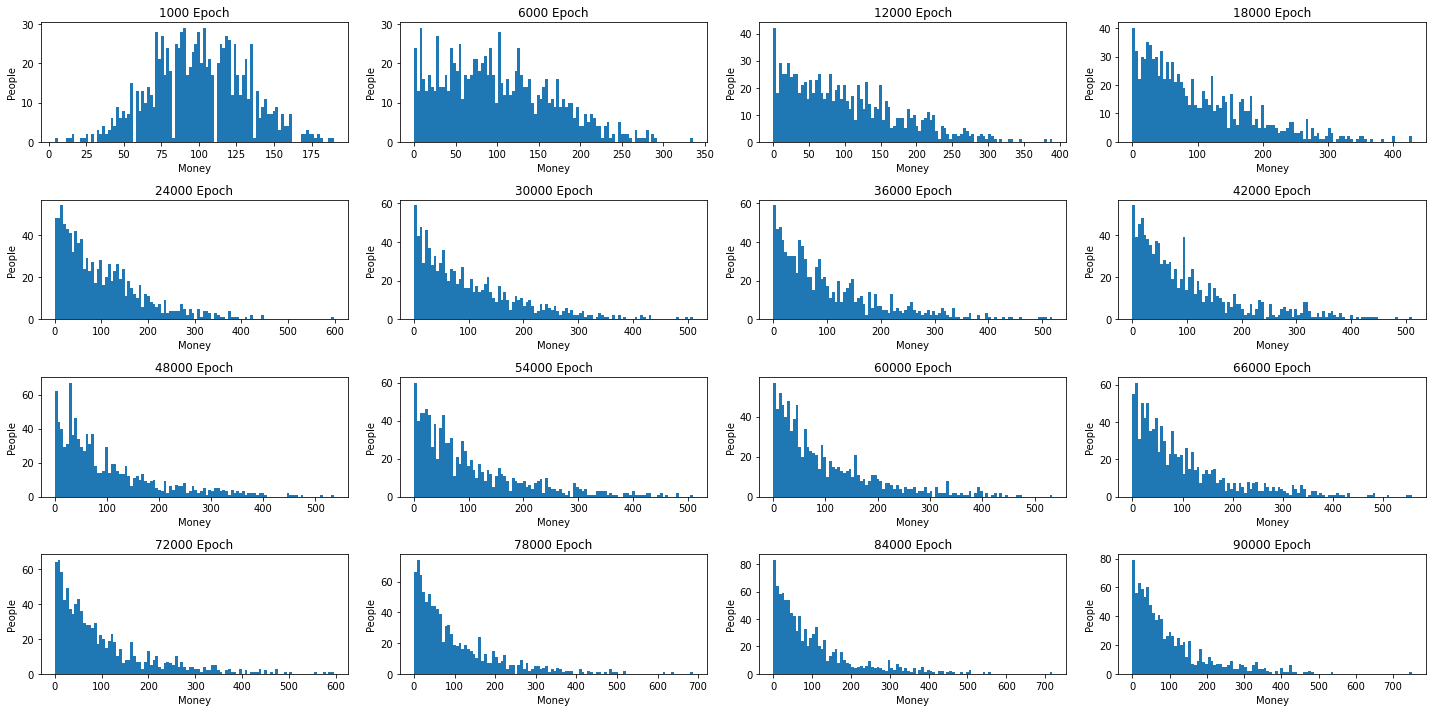

In [10]:
show_subplots(saved_vectors, 6, 1000)

Ниже представлена увеличенная гистограмма популяции на 1000 эпохе обменов

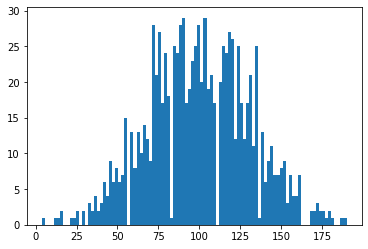

In [11]:
data = show_hist(saved_vectors[1])

Ниже представлено сравнение графиков теоретического и экспериментального распределений. Оранжевые точки обозначают часть людей(ось Y) с заданным кол-вом денег(oсь X)

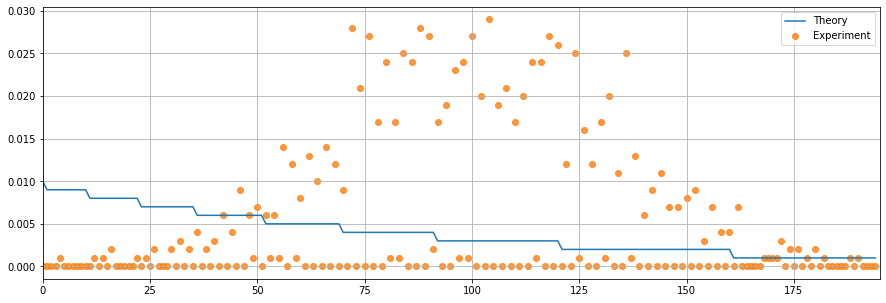

In [14]:
plot_theory_vs_experiment(population, saved_vectors[1])

Аналогично построим гистограмму и графики распределений на последней записанной эпохе

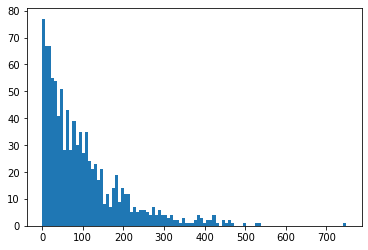

In [12]:
data = show_hist(saved_vectors[-1])

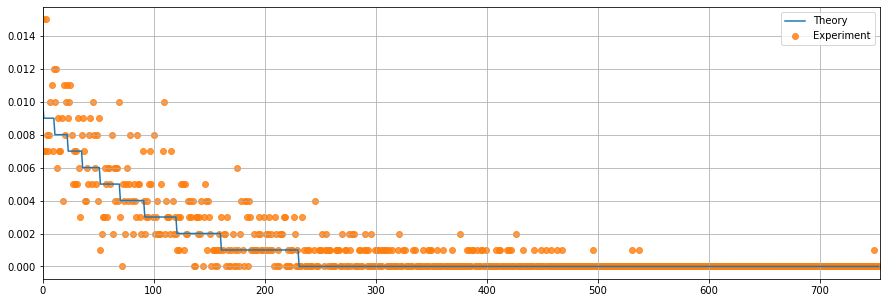

In [15]:
plot_theory_vs_experiment(population, saved_vectors[-1])

Сразу можно заметить, что распределение из нормального превратилось в экспоненциальное. Тем не менее, даже спустя 100.000 обменов оно довольно сильно отличается от теоретического.  
Ниже представлен график L2 нормы расстояния между теортическим вектором распределения богатства и экспериментальным. Сразу видим сильное падение после первой эпохи, связанное с тем, что изначальное распределение представляет собой дельта-функцию. Далее оно постепенно принимает вид нормального распределения до 5000 эпохи. Затем выходит к виду экспоненциального распределения и норма расстояния начинает осциллировать между значениями 0.002 и 0.001. Скорее всего это связано с тем, что система перешла в состояние равновесия.

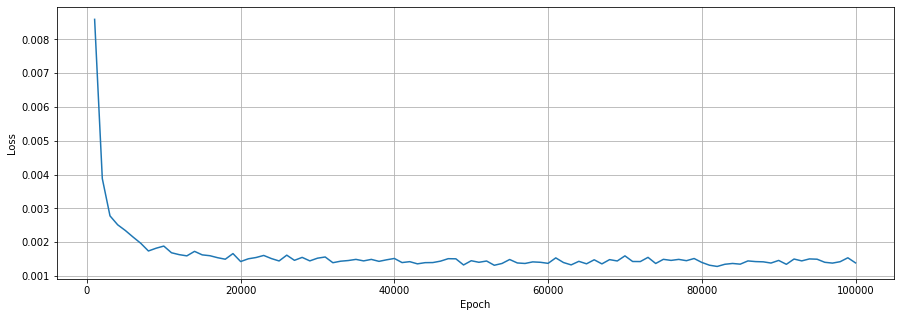

In [13]:
plot_loss_history(saved_losses, epochs_save)

В целом результат эксперимента оказался ожидаемым. Подобное поведение популяции обычно и описывается в статьях по социальной кинетике. В качестве примера можно привести распределение денег для разных уровней сохранения в популяции из статьи [Econophysics through computation](https://arxiv.org/abs/2001.04188).  

![](https://drive.google.com/uc?export=view&id=1dVtOlchxfHQUGCtpFjosfuQME8hX3hab)

Учитывая, что мы позволяли людям в популяции обнулять свой баланс, то нашему эксперименту соответствует кривая с нулевой лямбдой.

## Эксперимент 2 (уменьшение числа денег)
В данном эксперименте мы уменьшаем число денег у каждого человека в популяции для того, чтобы показать возросшую скорость сходимости к предельной кривой.

In [2]:
N_people = 1000
start_money = 10
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

Epoch: 1000. Current loss: 0.003056604:   1%|          | 1/100.0 [01:40<2:46:10, 100.72s/it]

1000 epochs take 100.70490574836731 seconds
Found new best loss!


Epoch: 3000. Current loss: 0.00290566:   3%|▎         | 3/100.0 [05:08<2:45:26, 102.33s/it] 

Found new best loss!


Epoch: 5000. Current loss: 0.002714286:   5%|▌         | 5/100.0 [08:35<2:42:59, 102.94s/it]

Found new best loss!


Epoch: 8000. Current loss: 0.002537037:   8%|▊         | 8/100.0 [13:48<2:39:09, 103.80s/it]

Found new best loss!


Epoch: 26000. Current loss: 0.002388889:  26%|██▌       | 26/100.0 [45:18<2:11:08, 106.33s/it]

Found new best loss!


Epoch: 88000. Current loss: 0.002303571:  88%|████████▊ | 88/100.0 [3:26:39<29:49, 149.12s/it]  

Found new best loss!


Epoch: 100000. Current loss: 0.002843137: 100%|██████████| 100/100.0 [3:48:59<00:00, 137.39s/it]


По сравнению с первым экспериментом видим, что за первую 1000 обменов система прошла фазы дельта функции и нормального распределения и сразу вышла к экспоненциальному виду. В течение дальнейших обменов приближется к нему ближе

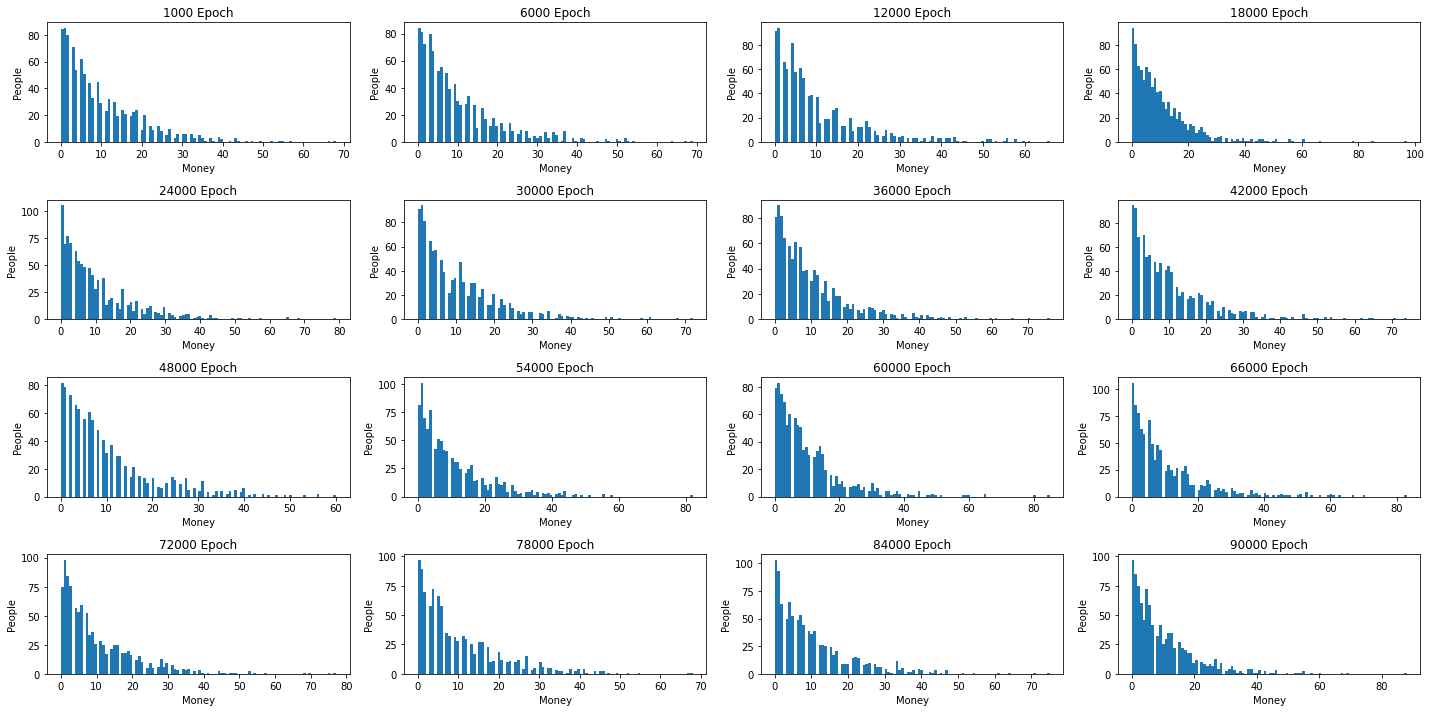

In [19]:
show_subplots(saved_vectors, 6, 1000)

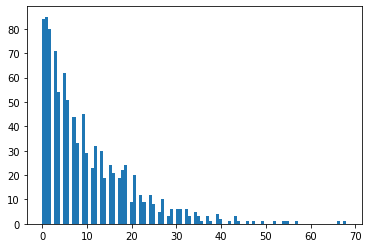

In [17]:
data = show_hist(saved_vectors[1])

По графикам сравнения теоретической и практической кривой видим, что уже на 1000 обмене кривые очень близки

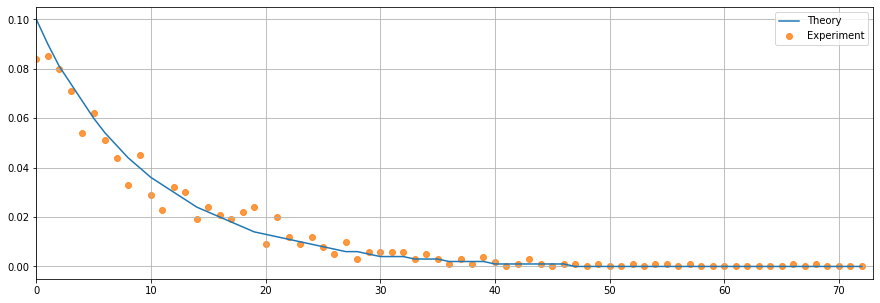

In [15]:
plot_theory_vs_experiment(population, saved_vectors[1])

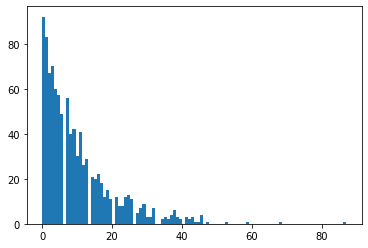

In [13]:
data = show_hist(saved_vectors[-1])

В дальнейшем точки стали еще ближе к кривой

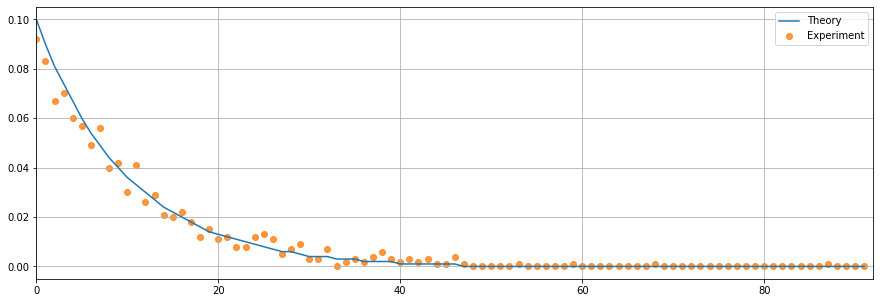

In [18]:
plot_theory_vs_experiment(population, saved_vectors[-1])

Что касается графика расстояния, то раз мы сохранили вектор с после 1000 обмена, то момент резкого уменьшения расстояния между распределения не попал на график. Поэтому мы наблюдаем лишь флуктуации, похожие на те, что видны в первом эксперименте после 10000 обмена.

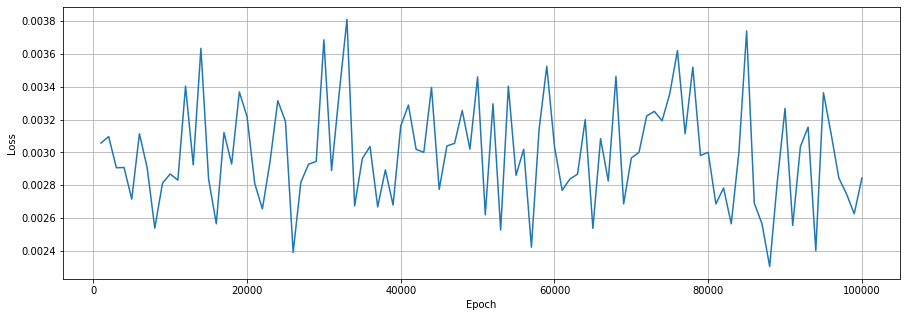

In [14]:
plot_loss_history(saved_losses, epochs_save)

По результатам эксперимента можно судить о том, что уменьшение числа денег на человека сильно ускоряет сходимость к теоретической предельной кривой. Одно из доказательств этому - более ранний переход в зону флуктуаций функции потерь.

## Эксперимент 3 (увеличение ставки в розыгрыше)
В данном эксперименте мы увеличиваем размер ставки до 5. Ожидается, что это ускорит сходимость к теоретической кривой, и, возможно увеличит число людей с нулевым балансом за счет того, что им будет проще проиграть весь свой капитал.

In [2]:
N_people = 1000
start_money = 100
bet_size = 5
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

  0%|          | 0/100.0 [00:00<?, ?it/s]

1000 epochs take 105.53317403793335 seconds


Epoch: 1000. Current loss: 0.010425:   1%|          | 1/100.0 [01:45<2:54:28, 105.74s/it]

Found new best loss!


Epoch: 2000. Current loss: 0.009811765:   2%|▏         | 2/100.0 [03:31<2:52:33, 105.65s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.009477273:   3%|▎         | 3/100.0 [05:16<2:50:46, 105.64s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.009266667:   4%|▍         | 4/100.0 [07:01<2:48:32, 105.34s/it]

Found new best loss!


Epoch: 8000. Current loss: 0.008967742:   8%|▊         | 8/100.0 [14:00<2:41:08, 105.09s/it]

Found new best loss!


Epoch: 14000. Current loss: 0.0086875:  14%|█▍        | 14/100.0 [24:34<2:31:46, 105.89s/it]  

Found new best loss!


Epoch: 52000. Current loss: 0.008424242:  52%|█████▏    | 52/100.0 [1:34:23<1:28:01, 110.04s/it]

Found new best loss!


Epoch: 100000. Current loss: 0.008778947: 100%|██████████| 100/100.0 [3:53:30<00:00, 140.10s/it]


Характер сходимости явно изменился. Сразу хочется отметить несколько эффектов:
1. Появление резких пиков, связанное с тем, что обмены происходят по 5 монет.
2. Распределение быстрее приходит к экспоненциальному виду, но дольше стабилизируется и приближается к теоретическому.
3. Появляются сверхбогатые люди. В данном эксперименте это заметно уже на 6000 обмене, в то время как в первом эксперименте такие люди появились лишь к 78000 обмену.

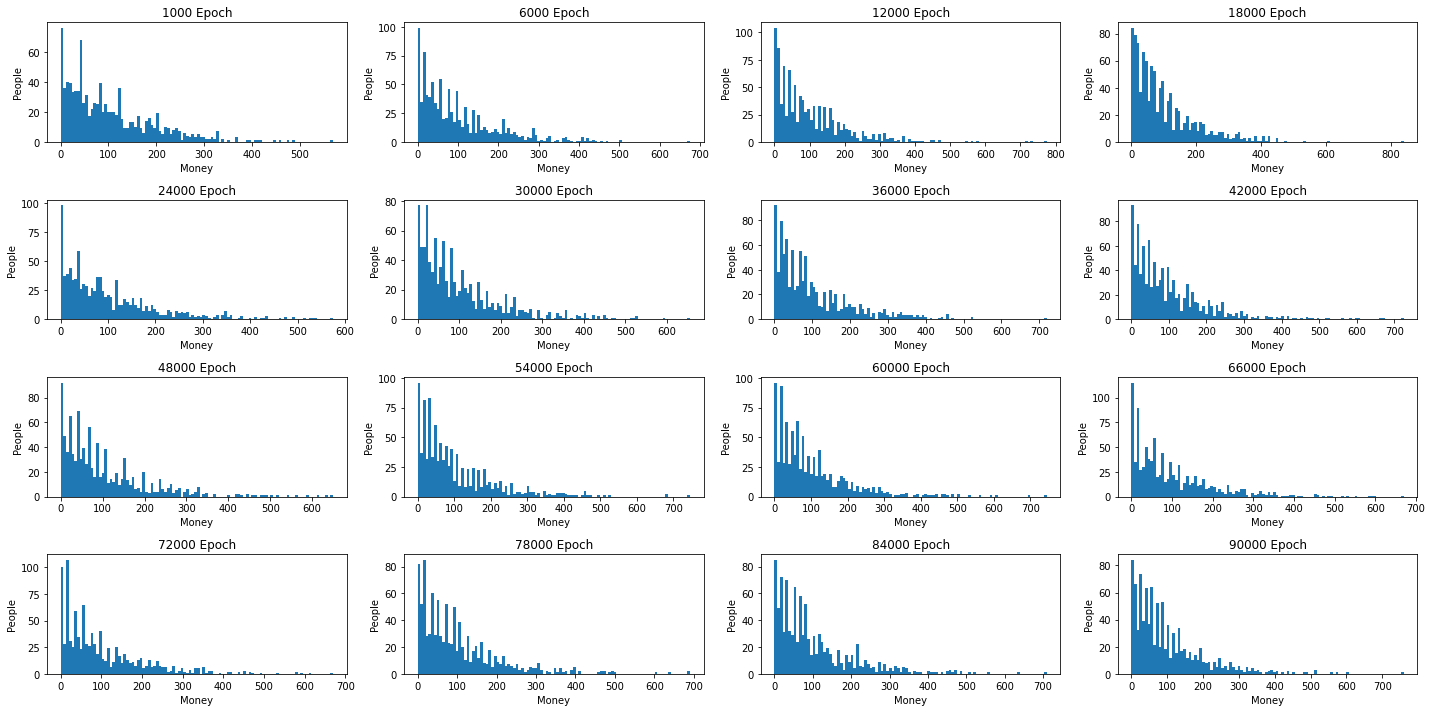

In [11]:
show_subplots(saved_vectors, 6, 1000)

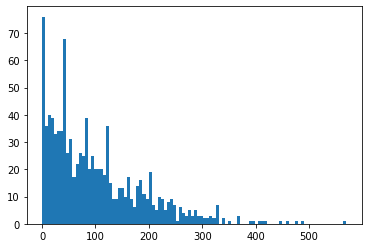

In [8]:
data = show_hist(saved_vectors[1])

Из-за того, что обмен деньгами происходит квантами по 5 единиц, теперь и у денег появились свои уровни. Оранжевая прослойка с нулевыми значениями - значения денег не кратные 5.

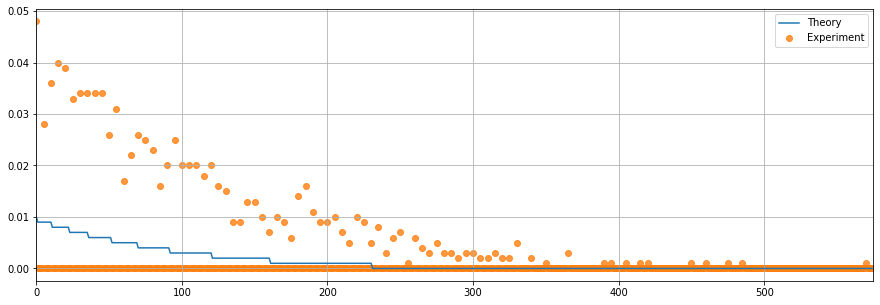

In [12]:
plot_theory_vs_experiment(population, saved_vectors[1])

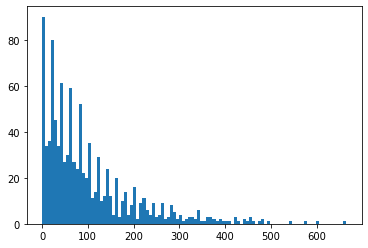

In [9]:
data = show_hist(saved_vectors[-1])

И на последней эпохе распределение сильно далеко от теоретического. Теперь у нас стало слишком много бедняков и слишком много богатых.

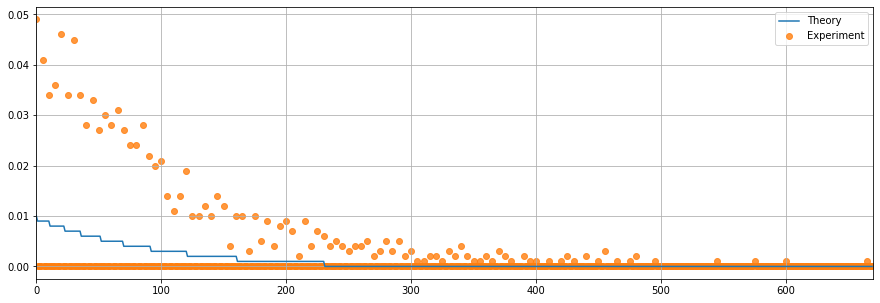

In [13]:
plot_theory_vs_experiment(population, saved_vectors[-1])

Касательно графика лосса, у нас произошло некоторое падение вначале, пока распределение приближалось к равновесному. В дальнейшем оно осциллирует и наврядли уменьшится, возможно из-за того, что теперь некоторые уровни денег стали недоступны.

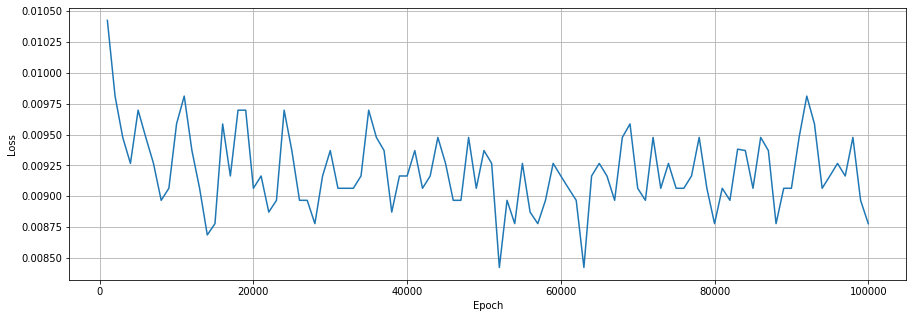

In [10]:
plot_loss_history(saved_losses, epochs_save)

В целом наблюдается значительно другая динамика. Отметим, что есть ощущение, что в данной постановке популяция никогда не придет к равновесию. Также интересен сильный дисбаланс классов. В эксперименте явно проявились появление большого числа бедных и некоторого числа сверхбогатых. И если появление первых можно обосновать в связи с тем, что люди стали чаще играть на весь свой баланс, то причина появления вторых неоднозначна. Скорее всего этим людям удается несколько раз подряд сорвать куш и вырваться вперед. А изначально они равновесно существуют между состояниями в 400 и 500 монет, ожидая своего ряда удачных выигрышей.

## Эксперимент 4 (социальная стратификация)
В данном эксперименте мы вводим социальную стратификацию на несколько классов:
* Бедный класс - 300 человек с достатком 10
* Средний класс - 500 человек с достатком 50
* Богатый класс - 200 человек с достатком 200

In [2]:
N_people = 1000
start_money = {10 : 300, 50 : 500, 100 : 200}
bet_size = 5
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

Epoch: 1000. Current loss: 0.01505556:   1%|          | 1/100.0 [01:47<2:56:46, 107.14s/it]

1000 epochs take 107.04413890838623 seconds
Found new best loss!


Epoch: 7000. Current loss: 0.01505556:   7%|▋         | 7/100.0 [12:35<2:47:23, 107.99s/it]

Found new best loss!


Epoch: 9000. Current loss: 0.01451786:   9%|▉         | 9/100.0 [16:11<2:43:57, 108.10s/it]

Found new best loss!


Epoch: 24000. Current loss: 0.01451786:  24%|██▍       | 24/100.0 [43:42<2:19:41, 110.28s/it]

Found new best loss!


Epoch: 78000. Current loss: 0.01401724:  78%|███████▊  | 78/100.0 [3:10:12<1:33:14, 254.29s/it]

Found new best loss!


Epoch: 100000. Current loss: 0.01563462: 100%|██████████| 100/100.0 [3:55:08<00:00, 141.09s/it]


Картина эволюции системы несколько изменилась, по сравнению с экспериментом, в котором у каждого человека в популяции одинаковое число денег. Я бы даже сказал, что в некотором смысле распределение стало более экспоненциальным. По крайней мере пропали резкие пики. Также уменьшилось количество денег у самого богатого человека в популяции. Ранее даже на ранних итерациях оно достигало 700-800. В данном эксперименте пороговое значение снизилось до 300-400.

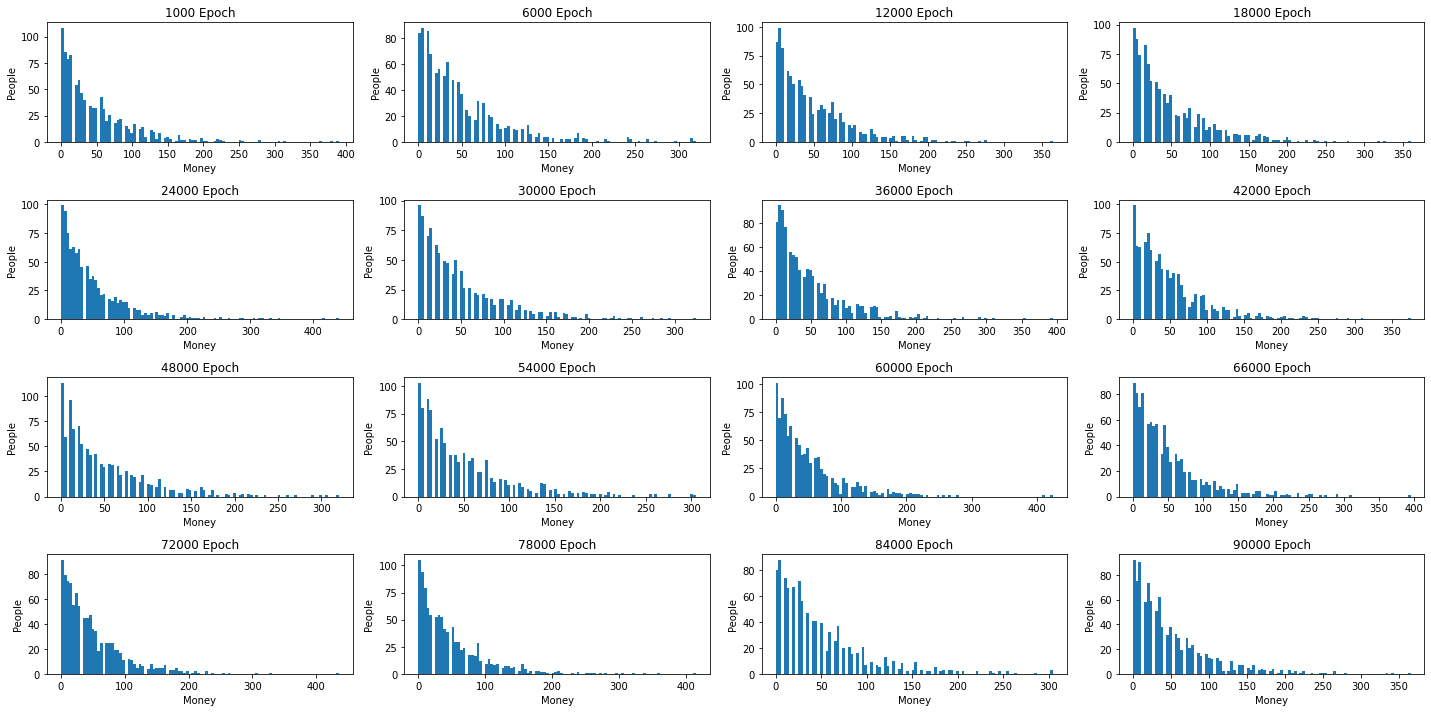

In [11]:
show_subplots(saved_vectors, 6, 1000)

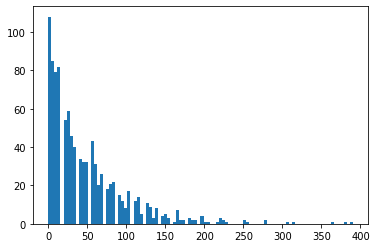

In [8]:
data = show_hist(saved_vectors[1])

Экспериментальное распределение все так же плохо сходится к теоретическому из-за наличия большого числа людей с нулевым балансом

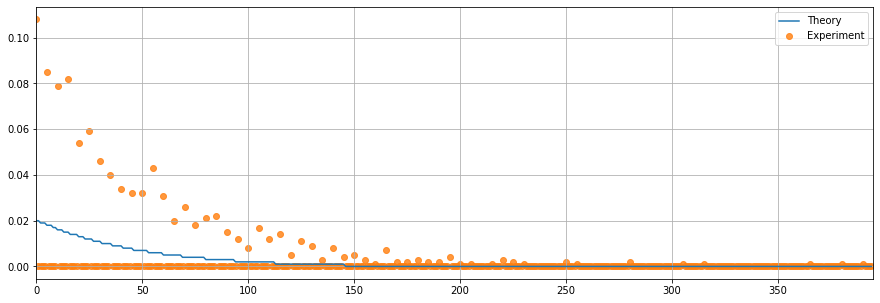

In [13]:
plot_theory_vs_experiment(population, saved_vectors[1])

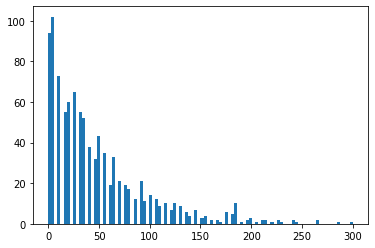

In [9]:
data = show_hist(saved_vectors[-1])

Причем это сохраняется вплоть до последних итераций

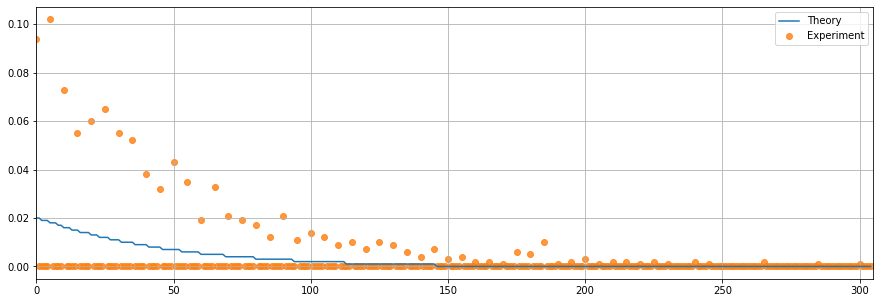

In [16]:
plot_theory_vs_experiment(population, saved_vectors[-1])

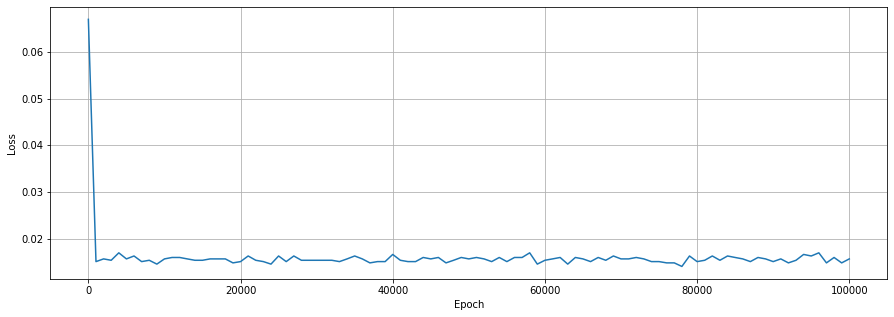

In [10]:
plot_loss_history(saved_losses, epochs_save)

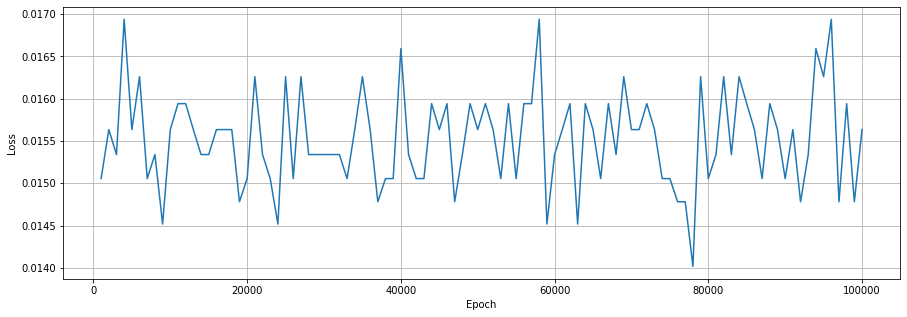

In [12]:
plot_loss_history(saved_losses[1:], epochs_save[1:])

Из-за того, что ставка была равна 5, у нас получились денежные уровни с шагом 5, что выглядит не сильно хорошо на графиках сравнения теоретического и экспериментального распределения достатка. В дальнейшем подобные эксперименты будем проводить со ставкой 1.

## Эксперимент 4.б (социальная стратификация, ставка 1)

Аналогичный эксперимент со стратификацией, однако ставка уменьшена до 1

In [17]:
N_people = 1000
start_money = {10 : 300, 50 : 500, 100 : 200}
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

Epoch: 1000. Current loss: 0.002270833:   1%|          | 1/100.0 [02:36<4:18:22, 156.59s/it]

1000 epochs take 156.47365355491638 seconds
Found new best loss!


Epoch: 2000. Current loss: 0.002070513:   2%|▏         | 2/100.0 [05:24<4:21:09, 159.90s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.001963415:   3%|▎         | 3/100.0 [07:59<4:16:11, 158.47s/it]

Found new best loss!


Epoch: 5000. Current loss: 0.001578035:   5%|▌         | 5/100.0 [13:22<4:12:38, 159.57s/it]

Found new best loss!


Epoch: 70000. Current loss: 0.00156044:  70%|███████   | 70/100.0 [2:55:42<1:14:03, 148.11s/it] 

Found new best loss!


Epoch: 77000. Current loss: 0.001536723:  77%|███████▋  | 77/100.0 [3:12:18<55:08, 143.87s/it]  

Found new best loss!


Epoch: 100000. Current loss: 0.001664773: 100%|██████████| 100/100.0 [4:05:13<00:00, 147.14s/it]


Сравнивая с экспериментом 1, проанализируем какие изменения вносит стратификация:
1. Пропущен переход к нормальному распределению. Мы быстрее сходимся к ожидаемому экспоненциальному распределению.
2. Денежная сумма наиболее богатого человека находится в районе 450, в то время как в первом эксперименте она достигала 700.  

Второй пункт интересен тем, что несмотря на то, что в популяции изначально были люди с большим балансом, это не позволило им прорваться к сумме в 700 монет. Возможно это связано с тем, что общая сумма денег изменилась.

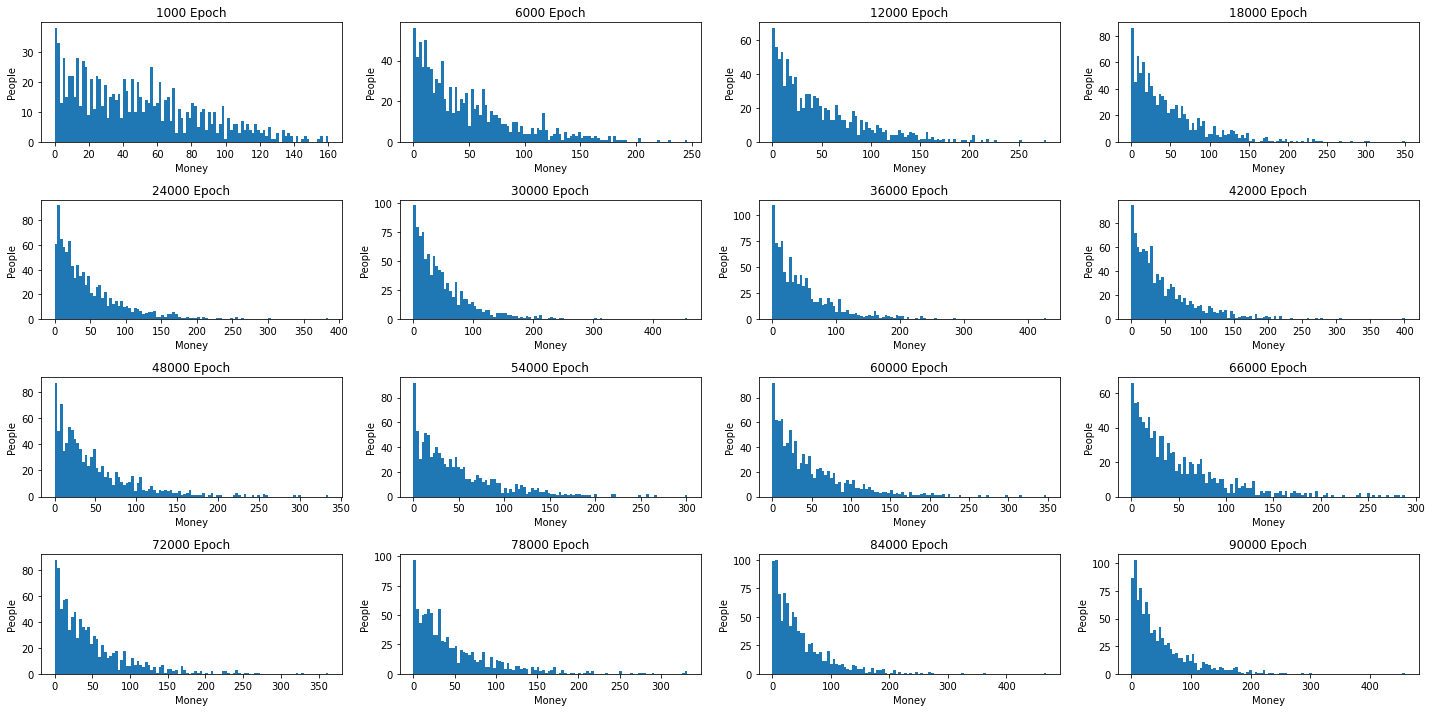

In [18]:
show_subplots(saved_vectors, 6, 1000)

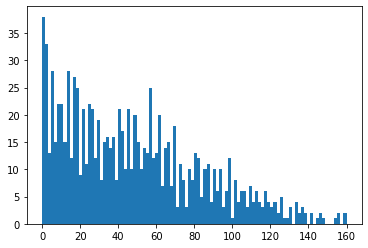

In [19]:
data = show_hist(saved_vectors[1])

Сходимость к теоретической зависимости вернулась к норме в связи с тем, что ставка стала равна 1

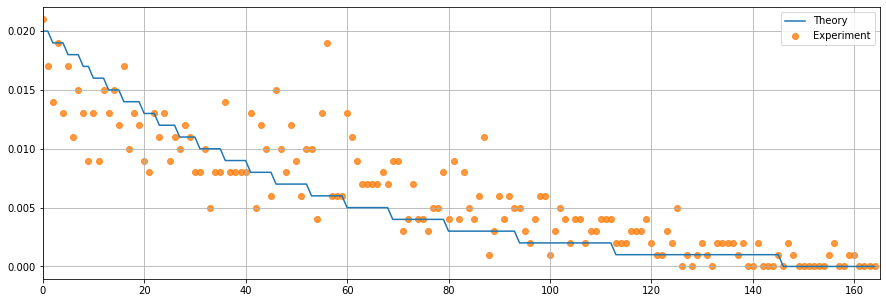

In [20]:
plot_theory_vs_experiment(population, saved_vectors[1])

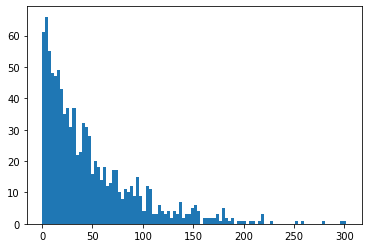

In [21]:
data = show_hist(saved_vectors[-1])

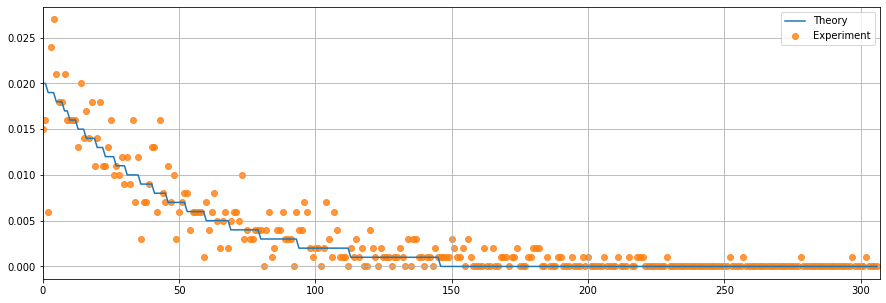

In [27]:
plot_theory_vs_experiment(population, saved_vectors[-1])

Стратификация позволила снизить кол-во итераций, требуемое для приближения к теоретическому распределению

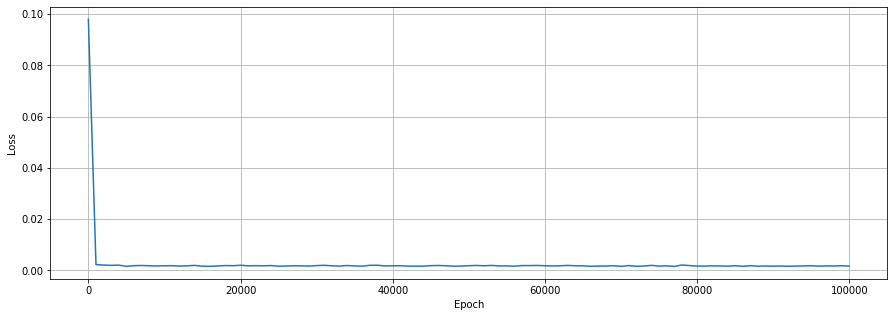

In [28]:
plot_loss_history(saved_losses, epochs_save)

Лосс продолжает флуктуации после первых итераций

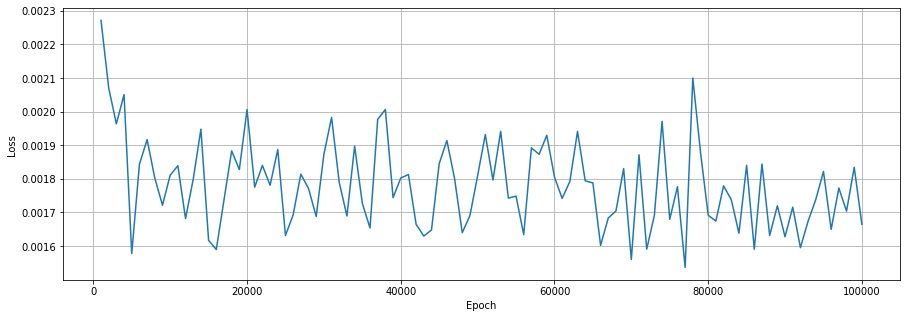

In [29]:
plot_loss_history(saved_losses[1:], epochs_save[1:])

В целом наблюдается ожидаемое поведение, как в первом эксперименте. Можно отметить более быструю скорость сходимости к ожидаемому распределению, что видно по лоссу. Интересен и тот факт, что уровень сверхбогатых людей снизился.

## Эксперимент 5 (увеличение числа человек)

В данном эксперименте число людей увеличено до 2000 по сравнению со вторым экспериментом. Сравниваемся с ним из-за того, что выдача 100 монет каждому человеку увеличивает экспериментальный вектор в 10 раз, из-за чего он перестает помещаться в память Юпитера

In [3]:
N_people = 2000
start_money = 10
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

  0%|          | 0/100.0 [00:00<?, ?it/s]

1000 epochs take 450.7344100475311 seconds


Epoch: 1000. Current loss: 0.001798246:   1%|          | 1/100.0 [07:31<12:25:31, 451.83s/it]

Found new best loss!


Epoch: 2000. Current loss: 0.001745455:   2%|▏         | 2/100.0 [15:05<12:19:05, 452.50s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.001633333:   4%|▍         | 4/100.0 [30:10<12:04:19, 452.70s/it]

Found new best loss!


Epoch: 6000. Current loss: 0.001622951:   6%|▌         | 6/100.0 [45:24<11:52:42, 454.92s/it]

Found new best loss!


Epoch: 14000. Current loss: 0.001590909:  14%|█▍        | 14/100.0 [2:35:03<21:45:47, 911.02s/it] 

Found new best loss!


Epoch: 17000. Current loss: 0.001558333:  17%|█▋        | 17/100.0 [2:58:06<14:11:15, 615.37s/it]

Found new best loss!


Epoch: 24000. Current loss: 0.001518182:  24%|██▍       | 24/100.0 [3:51:27<9:51:39, 467.10s/it] 

Found new best loss!


Epoch: 30000. Current loss: 0.001353448:  30%|███       | 30/100.0 [4:50:11<11:38:20, 598.57s/it]

Found new best loss!


Epoch: 68000. Current loss: 0.001084746:  68%|██████▊   | 68/100.0 [10:48:28<4:48:01, 540.04s/it]

Found new best loss!


Epoch: 100000. Current loss: 0.001745763: 100%|██████████| 100/100.0 [16:20:18<00:00, 588.18s/it]


С малым числом денег скорость сходимости к теоретической зависимости все так же высока. Не наблюдаю особых изменений по сравнению с экспериментом с 1000 человек

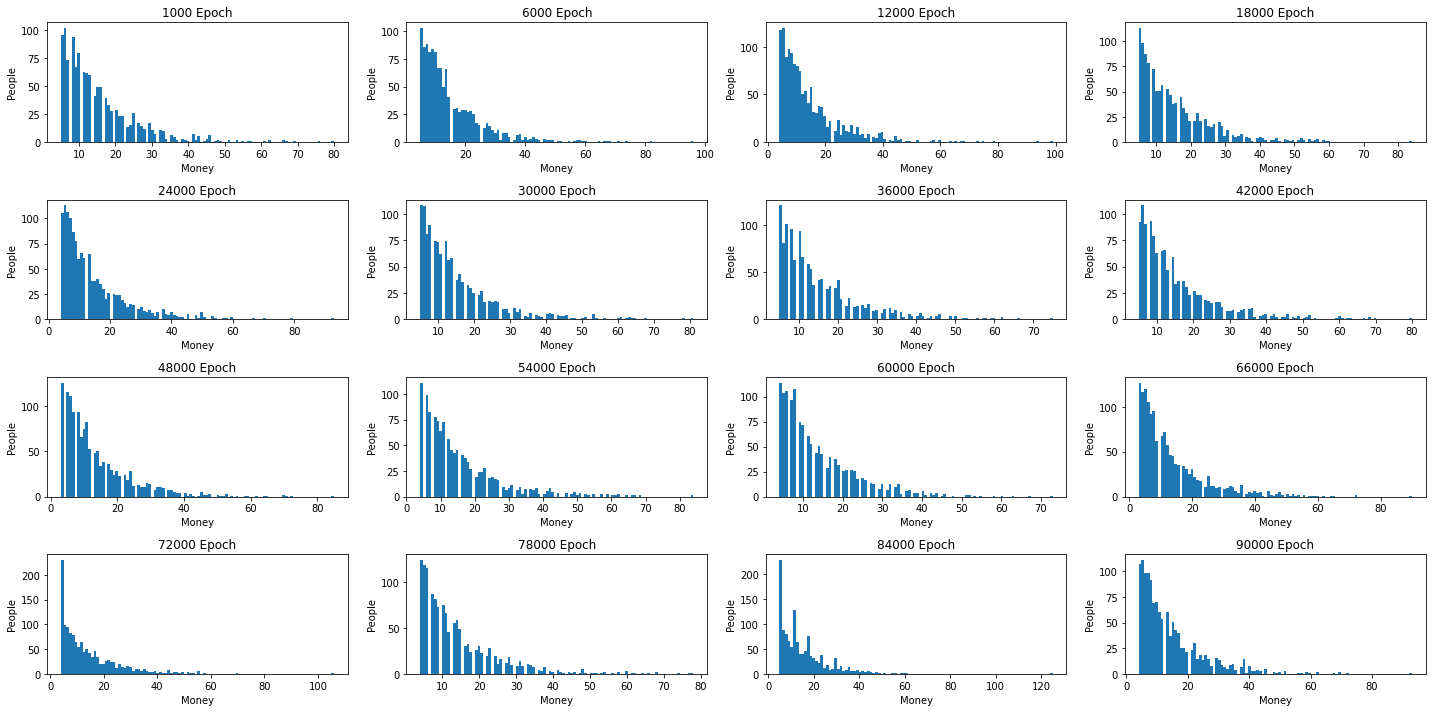

In [6]:
show_subplots(saved_vectors, 6, 1000)

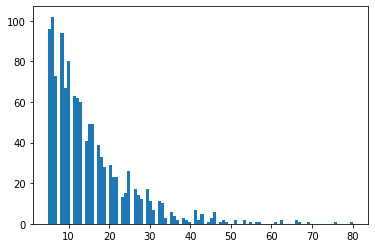

In [7]:
data = show_hist(saved_vectors[1])

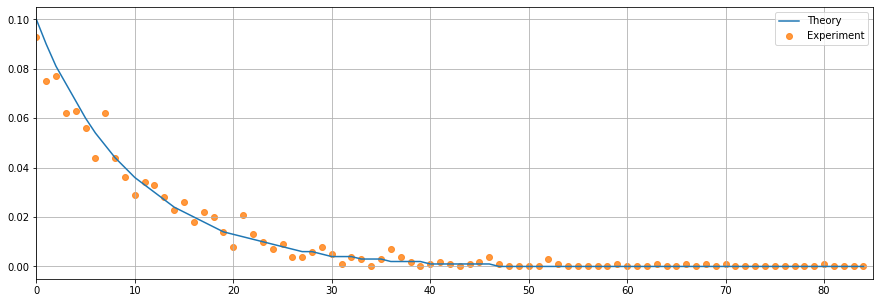

In [23]:
plot_theory_vs_experiment(population, saved_vectors[1])

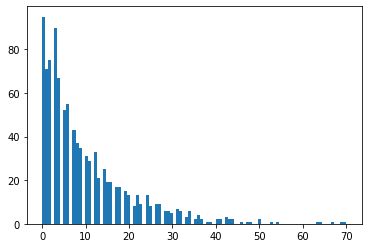

In [24]:
data = show_hist(saved_vectors[-1])

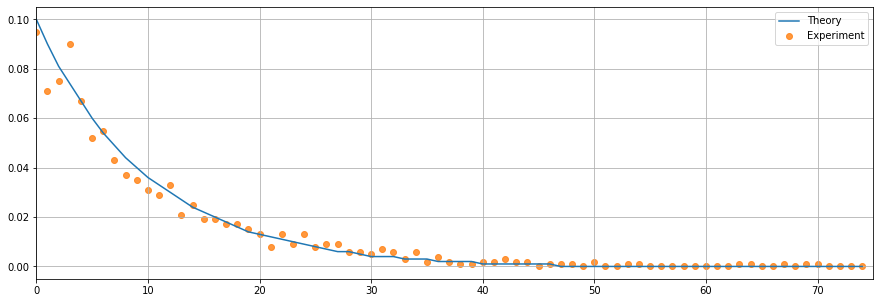

In [25]:
plot_theory_vs_experiment(population, saved_vectors[-1])

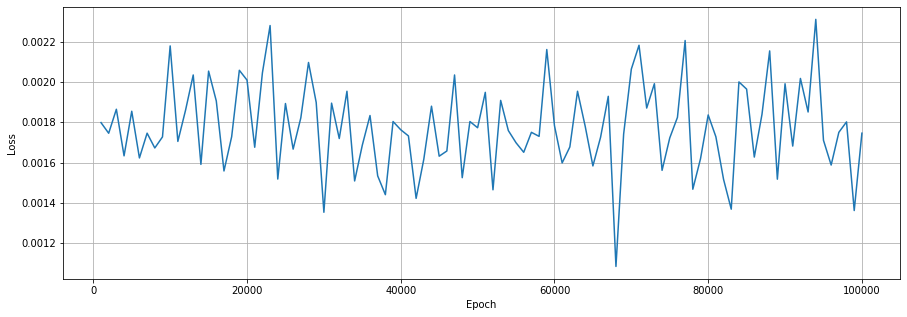

In [10]:
plot_loss_history(saved_losses, epochs_save)

Не заметил особо сильных изменений в поведении модели. Скорее всего это связано с тем, что влияние числа человек должно проявить себя на логарифмических масштабах увеличения числа человек. Однако подобное увеличение популяции приводит к тому, что заканчивается память. Попробую увеличить число человек еще больше.

## Эксперимент 6 (дальнейшее увеличение числа человек)

In [2]:
N_people = 2500
start_money = 10
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

Epoch: 1000. Current loss: 0.001718518:   1%|          | 1/100.0 [11:59<19:47:45, 719.85s/it]

1000 epochs take 719.7108745574951 seconds
Found new best loss!


Epoch: 2000. Current loss: 0.001466667:   2%|▏         | 2/100.0 [24:04<19:38:18, 721.41s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.001274576:   3%|▎         | 3/100.0 [36:11<19:28:48, 722.97s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.001042857:   4%|▍         | 4/100.0 [48:18<19:18:34, 724.11s/it]

Found new best loss!


Epoch: 22000. Current loss:  0.00102:  22%|██▏       | 22/100.0 [5:37:42<20:30:06, 946.24s/it]    

Found new best loss!


Epoch: 100000. Current loss: 0.001496552: 100%|██████████| 100/100.0 [25:01:43<00:00, 901.03s/it]  


К сожалению, добавление 500 человек не оказало сколь-нибудь большого влияния на поведение модели. Оно совпадает с предыдущими экспериментами 2 и 5.

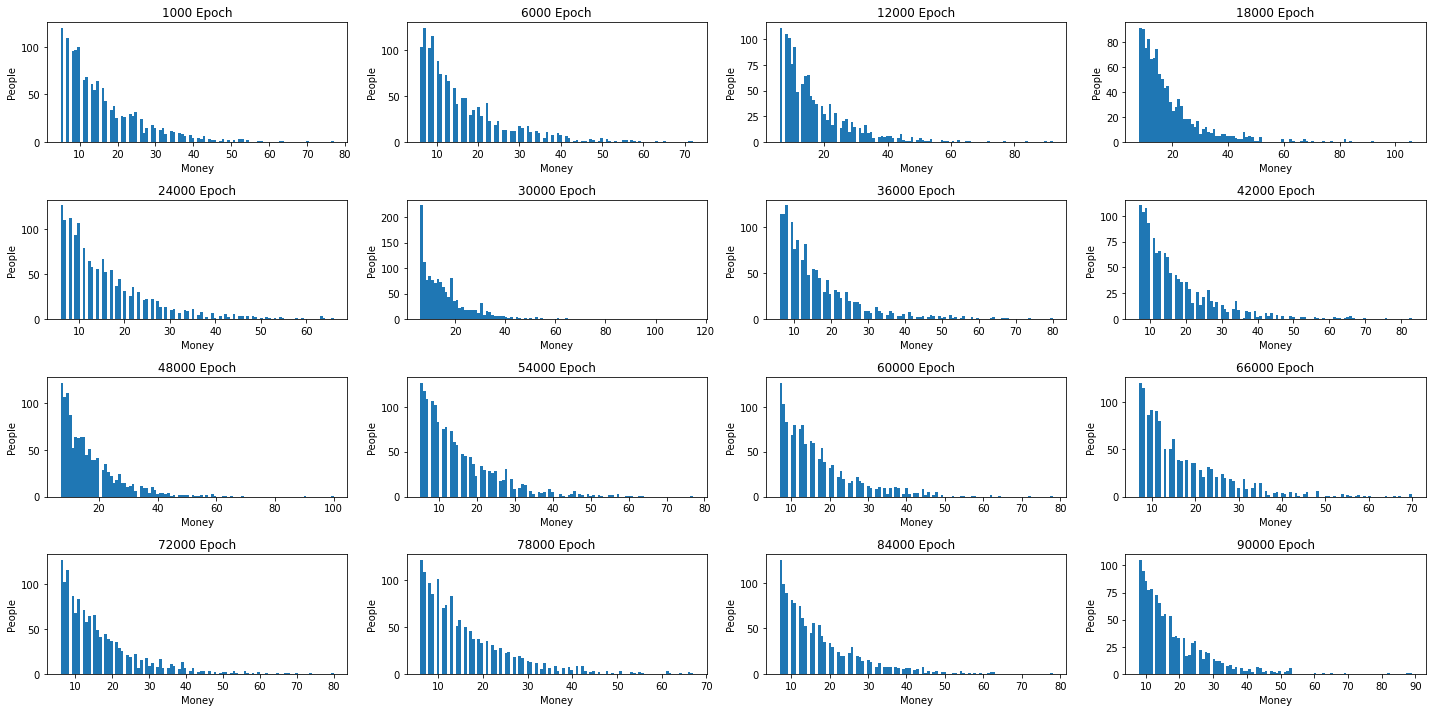

In [5]:
show_subplots(saved_vectors, 6, 1000)

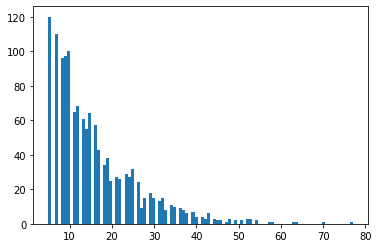

In [6]:
data = show_hist(saved_vectors[1])

На данном этапе обнаружились некоторые проблемы в расчете экспериментальной зависимости. Скорее всего они связаны с увеличением числа человек, возможно с вычислительными ошибками. Подобной проблемы не возникает во всех остальных экспериментах. Отладка кода не позволила выявить проблему.

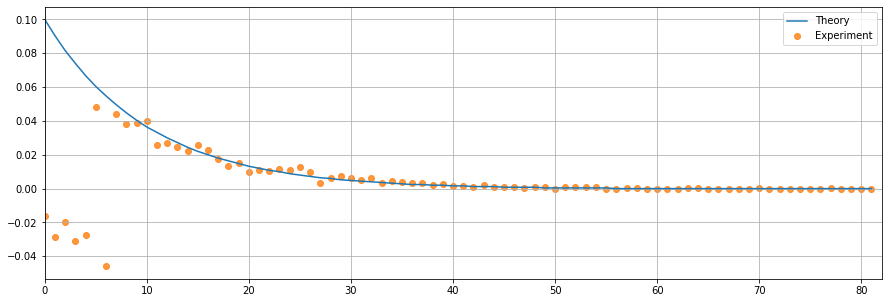

In [14]:
plot_theory_vs_experiment(population, saved_vectors[1])

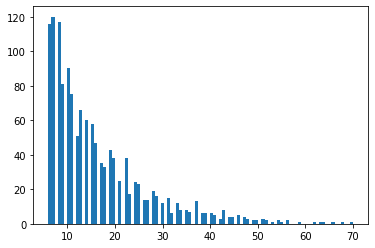

In [8]:
data = show_hist(saved_vectors[-1])

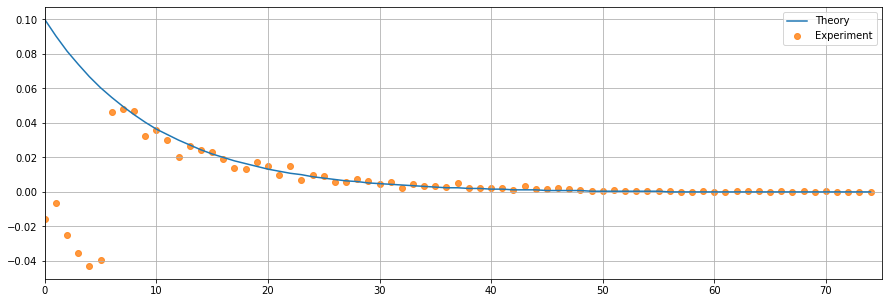

In [9]:
plot_theory_vs_experiment(population, saved_vectors[-1])

Тем не менее значения функции потерь не сильно сместилось по сравнению с предыдущими экспериментами. Вероятно проблема находится в функции отрисовки теоретической и экспериментальной зависимостей

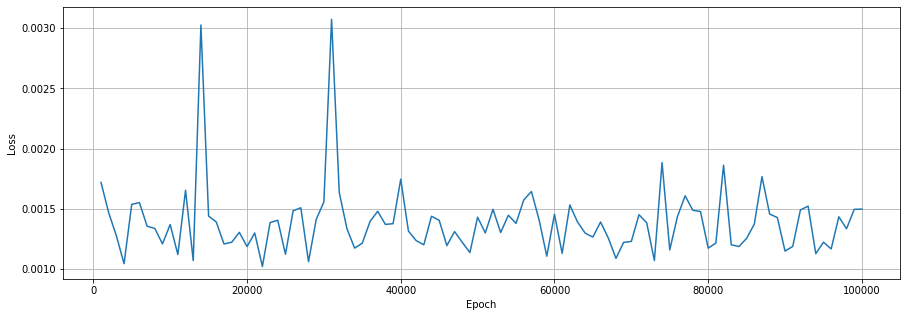

In [10]:
plot_loss_history(saved_losses, epochs_save)

Эксперименты по увеличению числа человек не оказали сколько-нибудь большого влияния на модель. Скорее всего это связано с тем, что увеличение числа человек было незначительным для проявления эффектов. Ввиду того, что ограничения по памяти не позволяют далее увеличивать размер популяции, подобные эксперименты были прекращены

## Эксперимент 7 (стратификация на богатых и бедных)

Эксперимент аналогичен эксперименту 4 и 4.б. В данной стратификации, однако, мы имеем лишь два класса - бедных и сверхбогатых. Наша цель - пронаблюдать хвост распределения на ранних эпохах и проверить сумеет ли системы выйти в равновесное состояние.

In [8]:
N_people = 1000
start_money = {10 : 500, 200 : 500}
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True)

  0%|          | 0/100.0 [00:00<?, ?it/s]

1000 epochs take 173.03512358665466 seconds


Epoch: 1000. Current loss: 0.003009479:   1%|          | 1/100.0 [02:53<4:46:00, 173.34s/it]

Found new best loss!


Epoch: 2000. Current loss: 0.002228916:   2%|▏         | 2/100.0 [05:21<4:30:48, 165.80s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.001860806:   3%|▎         | 3/100.0 [08:15<4:31:59, 168.24s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.001829091:   4%|▍         | 4/100.0 [10:45<4:20:27, 162.79s/it]

Found new best loss!


Epoch: 5000. Current loss: 0.001615942:   5%|▌         | 5/100.0 [13:36<4:21:51, 165.39s/it]

Found new best loss!


Epoch: 6000. Current loss: 0.00158363:   6%|▌         | 6/100.0 [16:08<4:12:36, 161.23s/it] 

Found new best loss!


Epoch: 8000. Current loss: 0.001565972:   8%|▊         | 8/100.0 [21:27<4:04:29, 159.46s/it]

Found new best loss!


Epoch: 9000. Current loss: 0.00141196:   9%|▉         | 9/100.0 [24:04<4:00:37, 158.65s/it] 

Found new best loss!


Epoch: 15000. Current loss: 0.001398671:  15%|█▌        | 15/100.0 [38:48<3:26:37, 145.86s/it]

Found new best loss!


Epoch: 19000. Current loss: 0.001372093:  19%|█▉        | 19/100.0 [48:48<3:20:58, 148.86s/it]

Found new best loss!


Epoch: 22000. Current loss: 0.0013367:  22%|██▏       | 22/100.0 [56:11<3:11:44, 147.49s/it]  

Found new best loss!


Epoch: 33000. Current loss: 0.001281967:  33%|███▎      | 33/100.0 [1:22:55<2:46:56, 149.50s/it]

Found new best loss!


Epoch: 49000. Current loss: 0.001254125:  49%|████▉     | 49/100.0 [2:03:24<2:09:38, 152.53s/it]

Found new best loss!


Epoch: 100000. Current loss: 0.001318937: 100%|██████████| 100/100.0 [4:04:14<00:00, 146.55s/it]


На первых итерациях видим ожидаемый хвост из богатых людей. Эволюция самого хвоста напоминает эволюцию первых экспериментов через нормальное распределение. Можно предположить, что каждая страта населения, разнесенная достаточно далеко в процессе эволюции превратится в нормальное распределение. Далее все страты сольются и перейдут в экспоненциальное распределение.  
Стоит также отметить, что в отличие от эксперимента с другой стратификацией, в этом эксперименте мы имеем сверхбогатых людей с балансом в 700-800 монет. Наверняка это люди из богатой страты получившие несколько выигрышей подряд и сохранившие свою позицию.

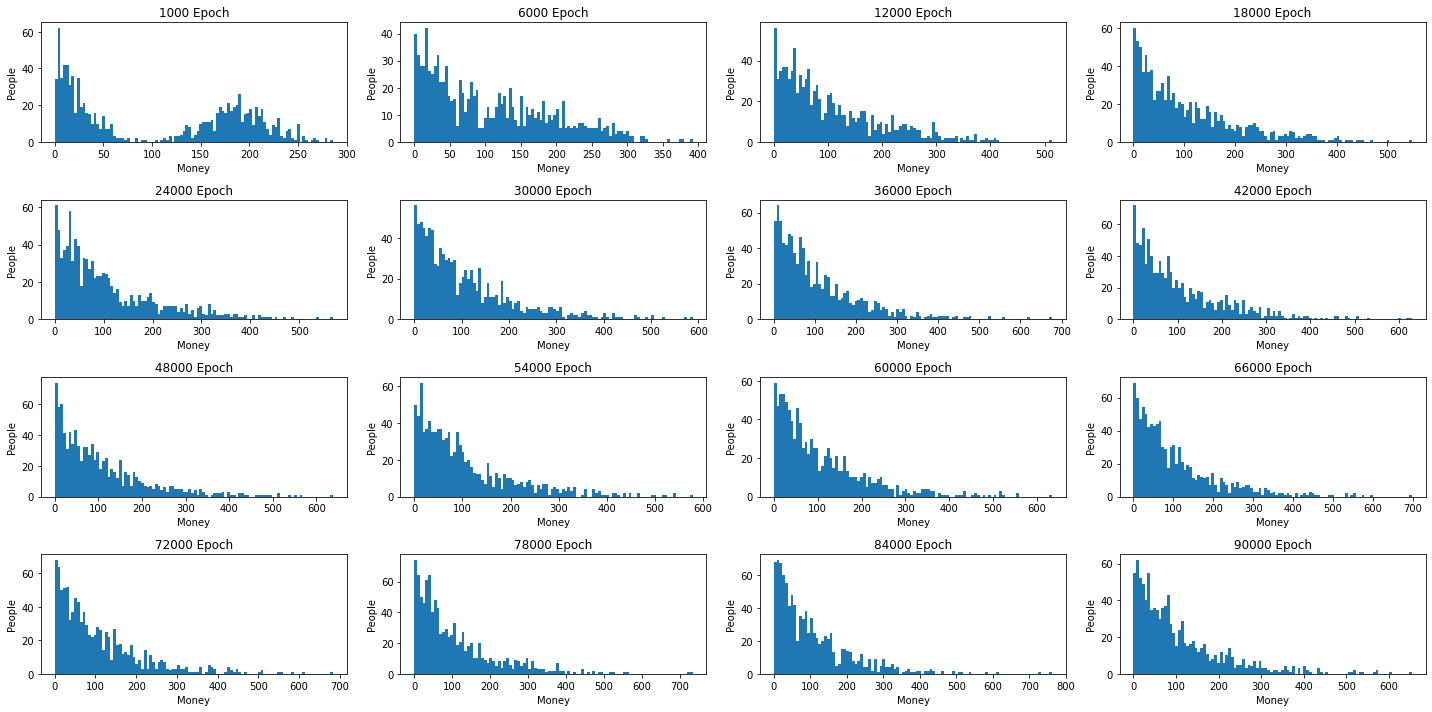

In [9]:
show_subplots(saved_vectors, 6, 1000)

Вот хвост богатых людей вблизи

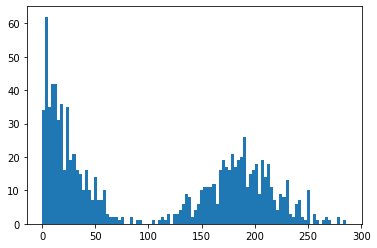

In [10]:
data = show_hist(saved_vectors[1])

И сравнение теоретического распределения с экспериментальным. Видим сильное расхождение с теорией

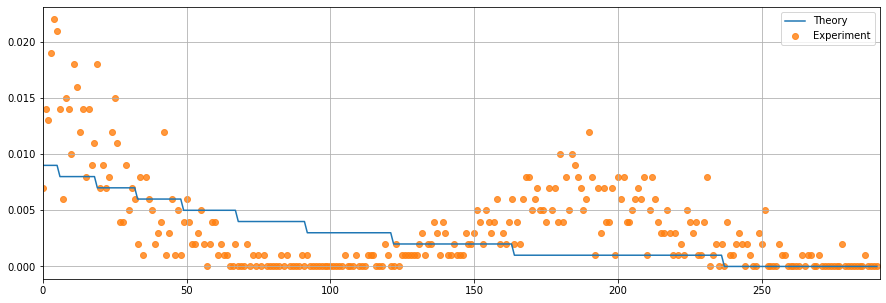

In [13]:
plot_theory_vs_experiment(population, saved_vectors[1])

И ожидаемо, экспериментальное распределение на последних эпохах приближается к теоретическому

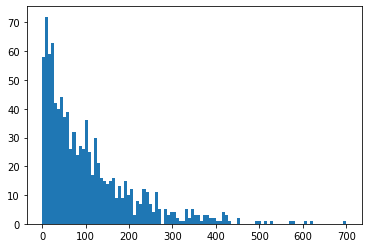

In [11]:
data = show_hist(saved_vectors[-1])

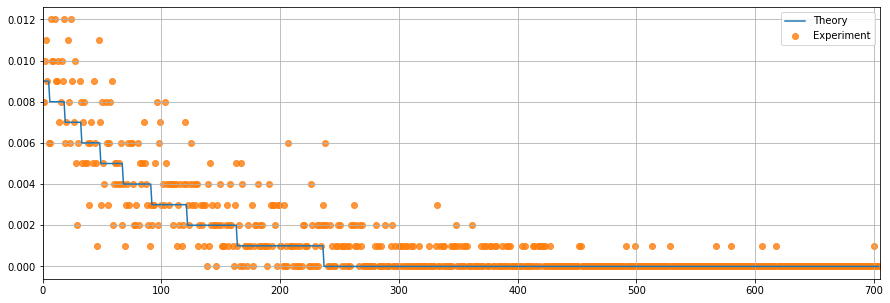

In [14]:
plot_theory_vs_experiment(population, saved_vectors[-1])

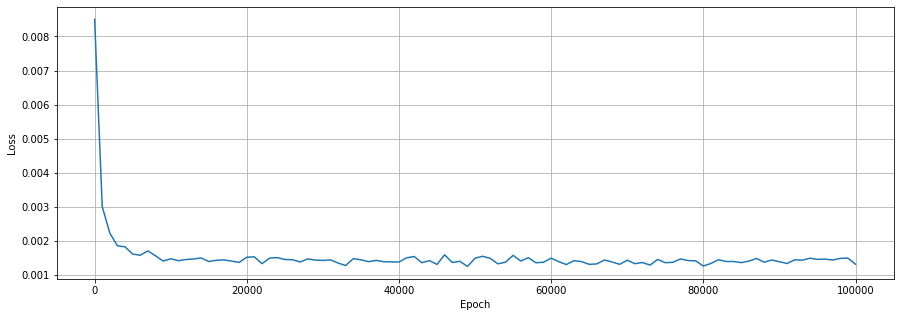

In [12]:
plot_loss_history(saved_losses, epochs_save)

## Эксперимент 8 (налогообложение 10%)

В данном эксперименте мы вводим периодическое налогообложение населения. Раз в 2000 итераций с каждого человека в популяции собирается налог в размере 10% от его текущего баланса. После этого собранная сумма равномерно распределяется по всей популяции. Оставшиеся деньги выдаются случайным людям в популяции по одной монете. Мы ожидаем появления горба в распределении около людей с нулевым балансом. Подобные результаты были получены в экспериментах в статье [Statistical mechanics of money](https://arxiv.org/abs/cond-mat/0001432#:~:text=In%20a%20closed%20economic%20system,of%20money%20per%20economic%20agent.)


![](https://drive.google.com/uc?export=view&id=1mIOa9NA7luNWoPwl-m7Gq6BogesWOXap)

In [4]:
N_people = 1000
start_money = 10
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000
tax_percentage = 0.1
tax_interval = 2000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True,
                                                        tax_percentage=tax_percentage, tax_interval=tax_interval)

Epoch: 1000. Current loss: 0.003471698:   1%|          | 1/100.0 [01:49<3:00:17, 109.27s/it]

1000 epochs take 109.24411511421204 seconds
Found new best loss!


Epoch: 2000. Current loss: 0.002824561:   2%|▏         | 2/100.0 [03:38<2:58:23, 109.22s/it]

Found new best loss!


Epoch: 8000. Current loss: 0.002770492:   8%|▊         | 8/100.0 [15:34<3:03:40, 119.79s/it]

Found new best loss!


Epoch: 11000. Current loss: 0.002557692:  11%|█         | 11/100.0 [22:39<3:20:51, 135.41s/it]

Found new best loss!


Epoch: 18000. Current loss: 0.002542373:  18%|█▊        | 18/100.0 [40:15<3:28:25, 152.51s/it]

Found new best loss!


Epoch: 19000. Current loss: 0.002436364:  19%|█▉        | 19/100.0 [43:05<3:33:06, 157.86s/it]

Found new best loss!


Epoch: 61000. Current loss: 0.002436364:  61%|██████    | 61/100.0 [2:26:03<1:37:22, 149.80s/it]

Found new best loss!


Epoch: 63000. Current loss: 0.002210526:  63%|██████▎   | 63/100.0 [2:30:58<1:31:24, 148.23s/it]

Found new best loss!


Epoch: 100000. Current loss: 0.003568627: 100%|██████████| 100/100.0 [3:58:43<00:00, 143.23s/it]


Поведение модели сохраняется, однако теперь мы можем наблюдать уширение полосы бедных людей с балансом от 0 до 5. Это говорит о том, что теперь люди с нулевым балансом начинают отходить от него за счет получения налоговых выплат. Это предоставляет людям, попавшим в ловушку нулевого баланса шанс выбраться

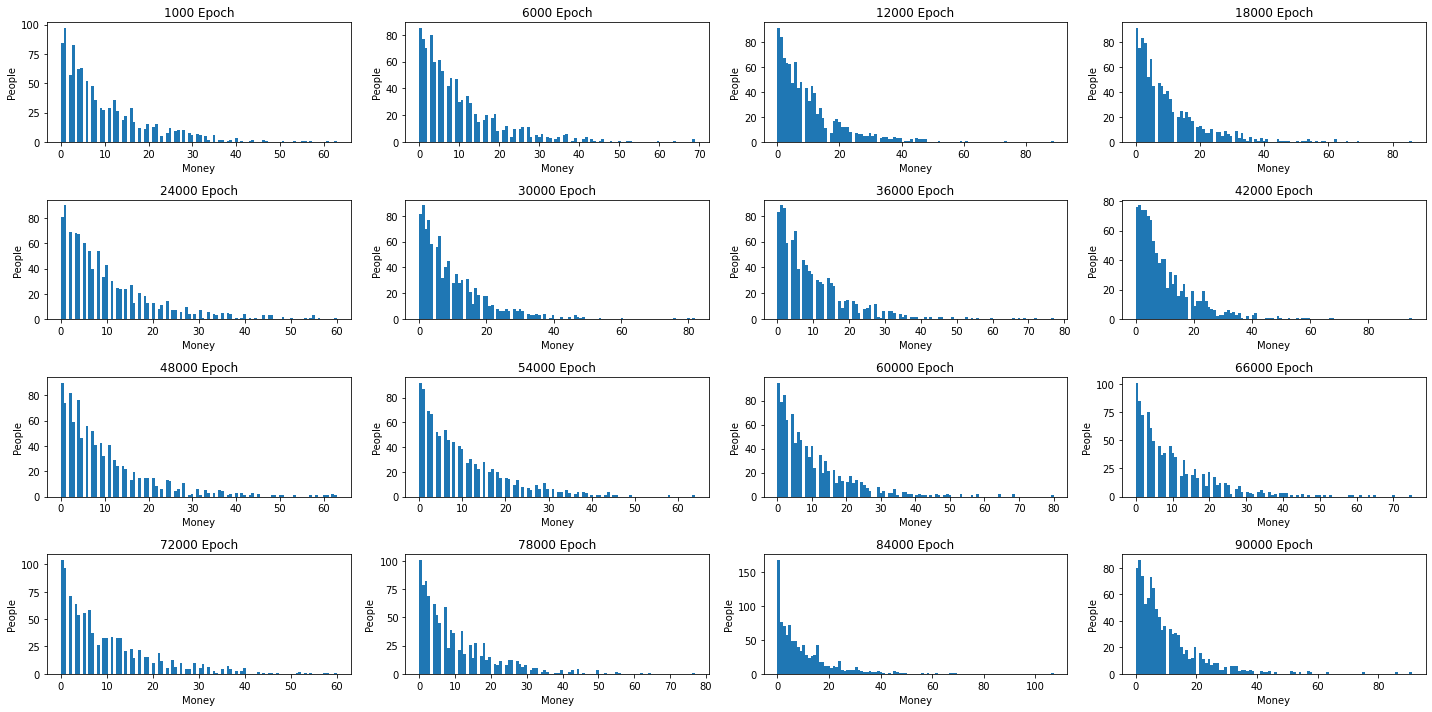

In [12]:
show_subplots(saved_vectors, 6, 1000)

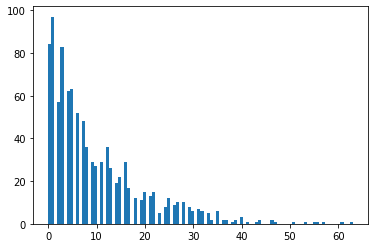

In [7]:
data = show_hist(saved_vectors[1])

Если присмотреться и сравнить графики с экспериментами без налогов, то можно увидеть начало формирования горба

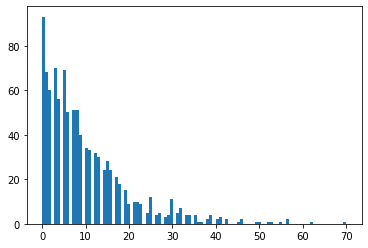

In [14]:
data = show_hist(saved_vectors[4])

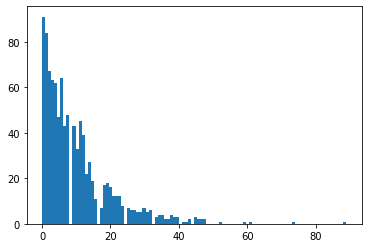

In [15]:
data = show_hist(saved_vectors[12])

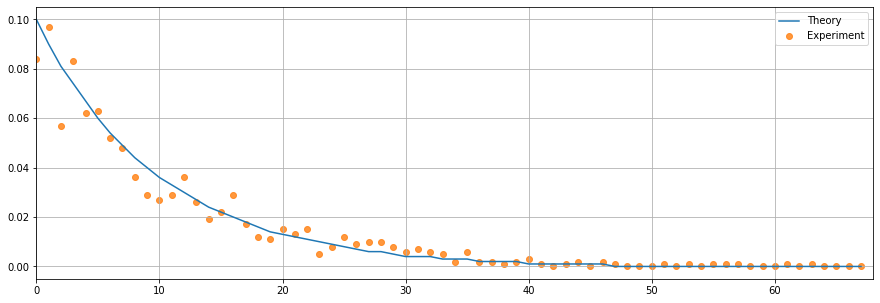

In [11]:
plot_theory_vs_experiment(population, saved_vectors[1])

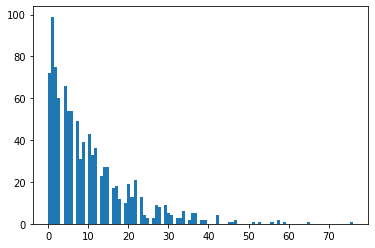

In [8]:
data = show_hist(saved_vectors[-1])

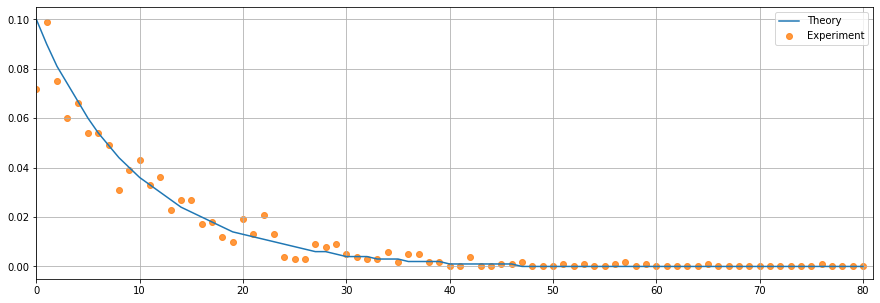

In [13]:
plot_theory_vs_experiment(population, saved_vectors[-1])

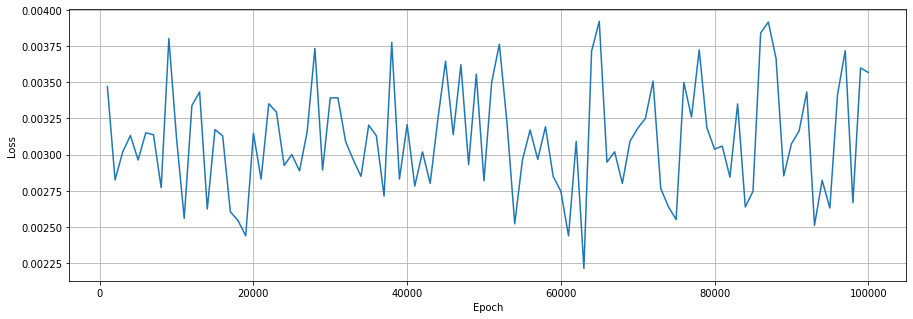

In [9]:
plot_loss_history(saved_losses, epochs_save)

## Эксперимент 9 (налогообложение 20%)

Увеличим налогообложение до 20% в надежде увидеть больший горб. Также увеличим число денег, чтобы замедлить сходимость и не пропустить появление горба.

In [2]:
N_people = 1000
start_money = 100
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000
tax_percentage = 0.2
tax_interval = 2000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True,
                                                        tax_percentage=tax_percentage, tax_interval=tax_interval)

  0%|          | 0/100.0 [00:00<?, ?it/s]

1000 epochs take 110.25783896446228 seconds


Epoch: 1000. Current loss: 0.007833333:   1%|          | 1/100.0 [01:51<3:03:10, 111.01s/it]

Found new best loss!


Epoch: 2000. Current loss: 0.003725888:   2%|▏         | 2/100.0 [03:45<3:03:14, 112.19s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.002837209:   3%|▎         | 3/100.0 [05:38<3:01:24, 112.21s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.002444444:   4%|▍         | 4/100.0 [07:30<2:59:39, 112.29s/it]

Found new best loss!


Epoch: 5000. Current loss: 0.002309322:   5%|▌         | 5/100.0 [09:24<2:58:17, 112.61s/it]

Found new best loss!


Epoch: 6000. Current loss: 0.002060729:   6%|▌         | 6/100.0 [11:21<2:58:33, 113.97s/it]

Found new best loss!


Epoch: 7000. Current loss:    0.002:   7%|▋         | 7/100.0 [13:12<2:55:20, 113.12s/it]   

Found new best loss!


Epoch: 8000. Current loss: 0.001869732:   8%|▊         | 8/100.0 [15:05<2:53:24, 113.09s/it]

Found new best loss!


Epoch: 9000. Current loss: 0.001805447:   9%|▉         | 9/100.0 [16:54<2:49:49, 111.97s/it]

Found new best loss!


Epoch: 11000. Current loss: 0.001736059:  11%|█         | 11/100.0 [20:32<2:43:53, 110.49s/it]

Found new best loss!


Epoch: 13000. Current loss: 0.001615672:  13%|█▎        | 13/100.0 [24:12<2:39:52, 110.26s/it]

Found new best loss!


Epoch: 15000. Current loss: 0.001603636:  15%|█▌        | 15/100.0 [27:55<2:36:56, 110.78s/it]

Found new best loss!


Epoch: 16000. Current loss: 0.001595156:  16%|█▌        | 16/100.0 [29:51<2:37:15, 112.33s/it]

Found new best loss!


Epoch: 17000. Current loss: 0.001425087:  17%|█▋        | 17/100.0 [31:40<2:34:13, 111.48s/it]

Found new best loss!


Epoch: 26000. Current loss: 0.00142268:  26%|██▌       | 26/100.0 [48:14<2:16:23, 110.59s/it] 

Found new best loss!


Epoch: 28000. Current loss: 0.001386986:  28%|██▊       | 28/100.0 [51:53<2:12:07, 110.10s/it]

Found new best loss!


Epoch: 33000. Current loss: 0.001375427:  33%|███▎      | 33/100.0 [1:01:10<2:04:10, 111.20s/it]

Found new best loss!


Epoch: 43000. Current loss: 0.001353147:  43%|████▎     | 43/100.0 [1:19:49<1:48:23, 114.09s/it]

Found new best loss!


Epoch: 66000. Current loss: 0.001324415:  66%|██████▌   | 66/100.0 [2:50:58<1:04:57, 114.62s/it] 

Found new best loss!


Epoch: 100000. Current loss: 0.001406897: 100%|██████████| 100/100.0 [3:53:26<00:00, 140.07s/it]


Сходимость замедлилась и горб стал явно шире и заметнее

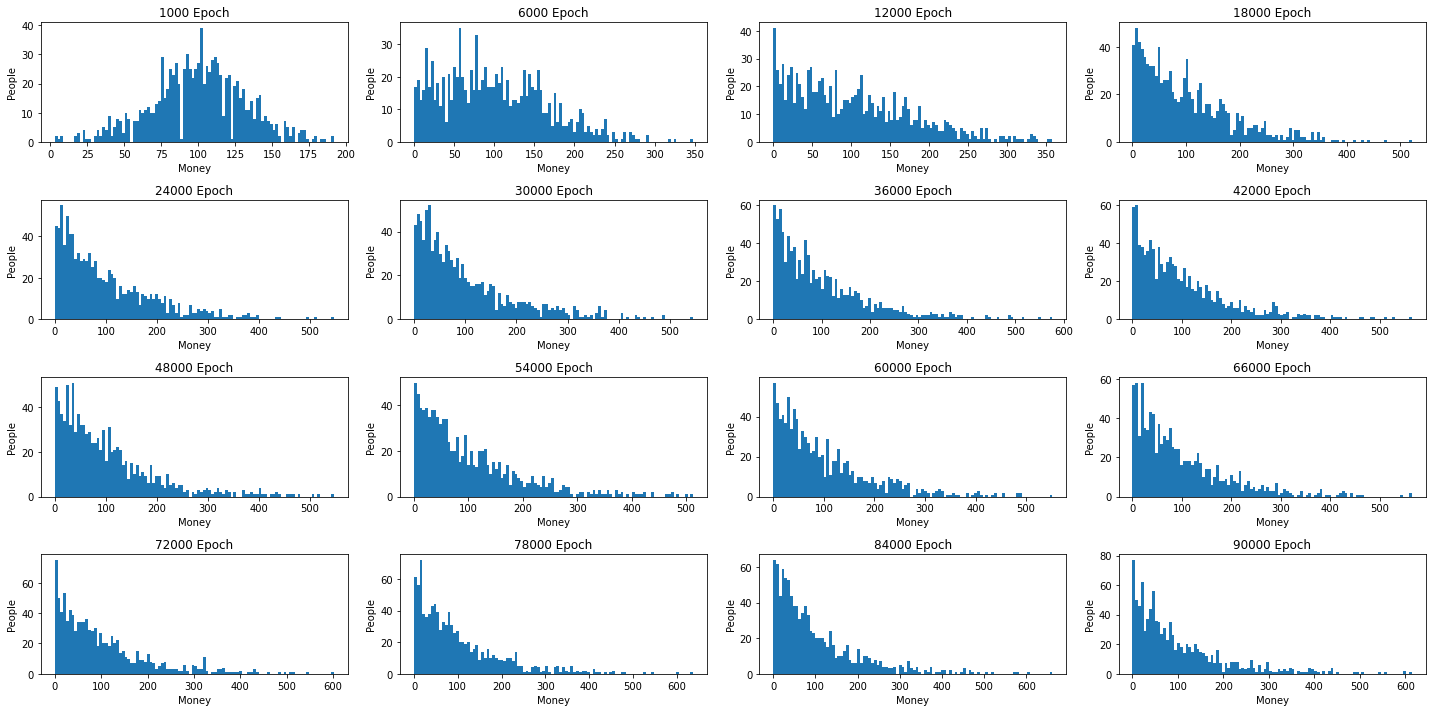

In [7]:
show_subplots(saved_vectors, 6, 1000)

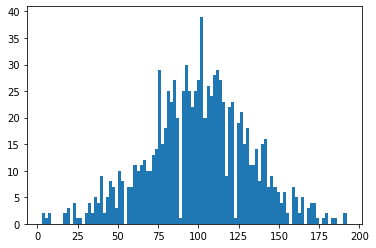

In [8]:
data = show_hist(saved_vectors[1])

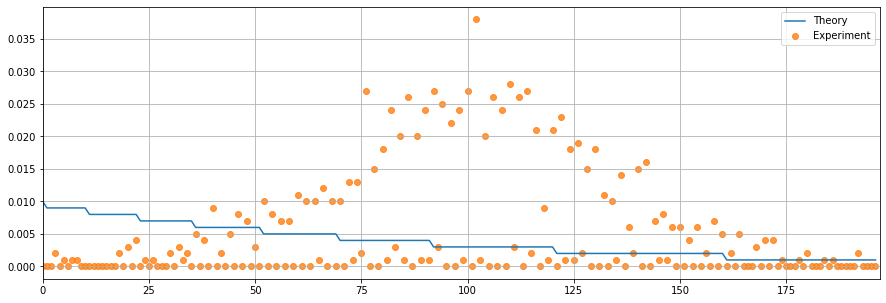

In [14]:
plot_theory_vs_experiment(population, saved_vectors[1])

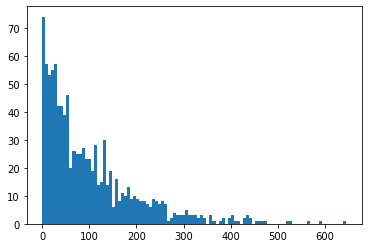

In [9]:
data = show_hist(saved_vectors[-1])

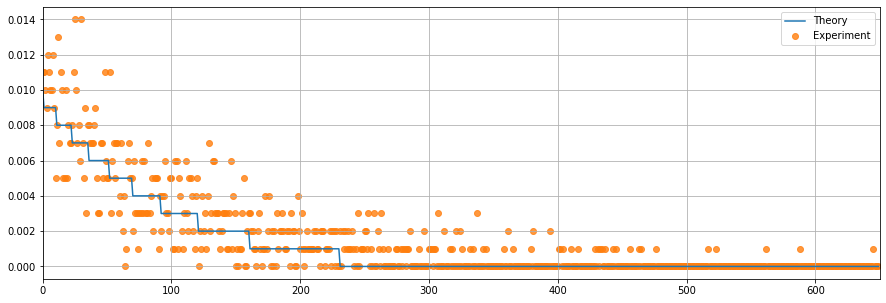

In [15]:
plot_theory_vs_experiment(population, saved_vectors[-1])

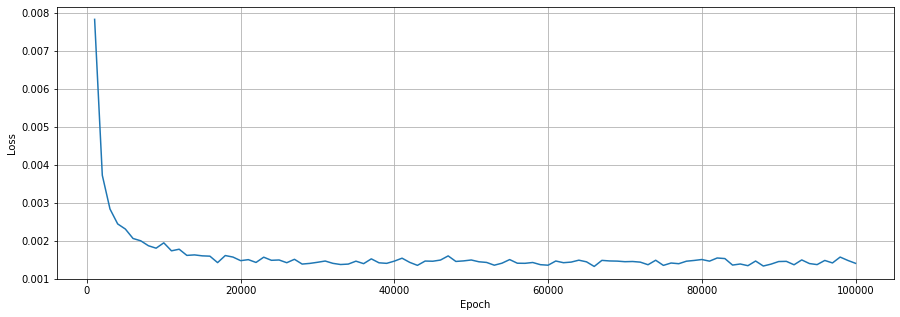

In [10]:
plot_loss_history(saved_losses, epochs_save)

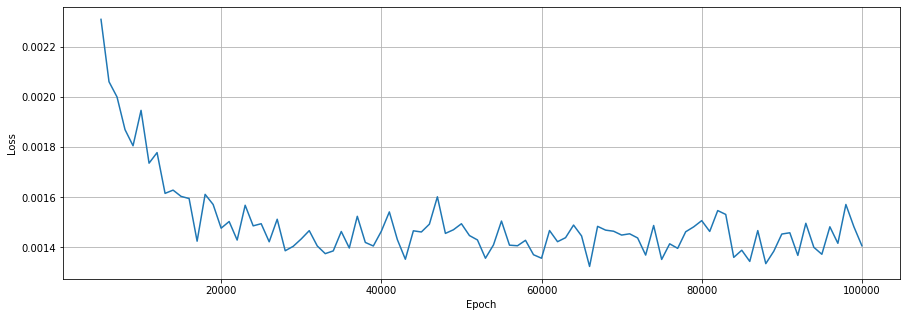

In [13]:
plot_loss_history(saved_losses[5:], epochs_save[5:])

## Эксперимент 10 (редкое налогообложение в размере 10%)

Посмотрим как повлияет более редкое налогообложение на процесс сходимости к теоретической зависимости

In [2]:
N_people = 1000
start_money = 100
bet_size = 1
num_of_iterations = 100000
log_iteration = 1000
tax_percentage = 0.1
tax_interval = 5000

population = Population(N_people, start_money, loss='L2', quantize_theory=True)
saved_vectors, saved_losses, epochs_save = train_epochs(population, epochs=num_of_iterations, logging_interval=log_iteration,
                                                        bet_size=bet_size, initial_vector_save=True,
                                                        tax_percentage=tax_percentage, tax_interval=tax_interval)

  0%|          | 0/100.0 [00:00<?, ?it/s]

1000 epochs take 108.62526631355286 seconds


Epoch: 1000. Current loss: 0.01008537:   1%|          | 1/100.0 [01:58<3:15:01, 118.19s/it]

Found new best loss!


Epoch: 2000. Current loss: 0.004248649:   2%|▏         | 2/100.0 [03:50<3:10:03, 116.36s/it]

Found new best loss!


Epoch: 3000. Current loss: 0.002926605:   3%|▎         | 3/100.0 [05:41<3:05:41, 114.86s/it]

Found new best loss!


Epoch: 4000. Current loss: 0.002444915:   4%|▍         | 4/100.0 [07:32<3:02:02, 113.77s/it]

Found new best loss!


Epoch: 5000. Current loss: 0.002160494:   5%|▌         | 5/100.0 [09:24<2:58:54, 112.99s/it]

Found new best loss!


Epoch: 6000. Current loss: 0.002129555:   6%|▌         | 6/100.0 [11:13<2:55:10, 111.82s/it]

Found new best loss!


Epoch: 7000. Current loss: 0.002067729:   7%|▋         | 7/100.0 [13:01<2:51:43, 110.79s/it]

Found new best loss!


Epoch: 8000. Current loss: 0.001948:   8%|▊         | 8/100.0 [14:52<2:50:04, 110.92s/it]   

Found new best loss!


Epoch: 9000. Current loss: 0.001832685:   9%|▉         | 9/100.0 [16:40<2:46:47, 109.97s/it]

Found new best loss!


Epoch: 10000. Current loss: 0.001763158:  10%|█         | 10/100.0 [18:27<2:43:44, 109.16s/it]

Found new best loss!


Epoch: 11000. Current loss: 0.001744275:  11%|█         | 11/100.0 [20:16<2:41:39, 108.98s/it]

Found new best loss!


Epoch: 12000. Current loss: 0.001730038:  12%|█▏        | 12/100.0 [22:04<2:39:32, 108.78s/it]

Found new best loss!


Epoch: 13000. Current loss: 0.001639405:  13%|█▎        | 13/100.0 [23:53<2:37:35, 108.68s/it]

Found new best loss!


Epoch: 14000. Current loss: 0.001503597:  14%|█▍        | 14/100.0 [25:42<2:35:55, 108.78s/it]

Found new best loss!


Epoch: 21000. Current loss: 0.001447917:  21%|██        | 21/100.0 [38:25<2:23:48, 109.22s/it]

Found new best loss!


Epoch: 24000. Current loss: 0.001432056:  24%|██▍       | 24/100.0 [43:56<2:18:54, 109.66s/it]

Found new best loss!


Epoch: 35000. Current loss: 0.001371622:  35%|███▌      | 35/100.0 [1:03:49<1:57:32, 108.50s/it]

Found new best loss!


Epoch: 40000. Current loss: 0.001315615:  40%|████      | 40/100.0 [1:13:01<1:49:39, 109.66s/it]

Found new best loss!


Epoch: 68000. Current loss: 0.001293919:  68%|██████▊   | 68/100.0 [2:54:14<1:00:38, 113.71s/it] 

Found new best loss!


Epoch: 100000. Current loss: 0.001406897: 100%|██████████| 100/100.0 [3:53:04<00:00, 139.84s/it]


По сравнению с экспериментом 8 опять же видим более явное проявление горба, связанное с увеличением числа денег у каждого человека в популяции. В остальном ничего нового

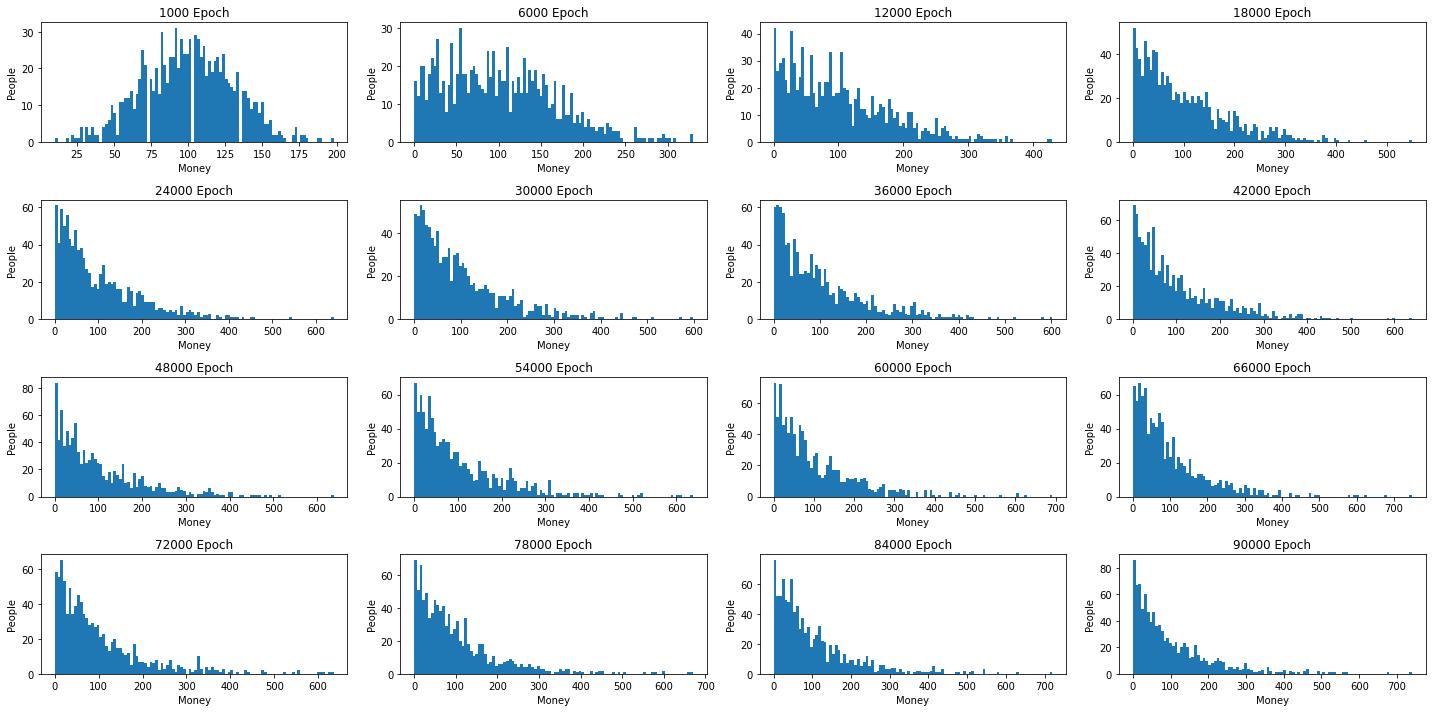

In [7]:
show_subplots(saved_vectors, 6, 1000)

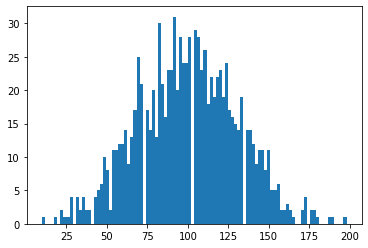

In [8]:
data = show_hist(saved_vectors[1])

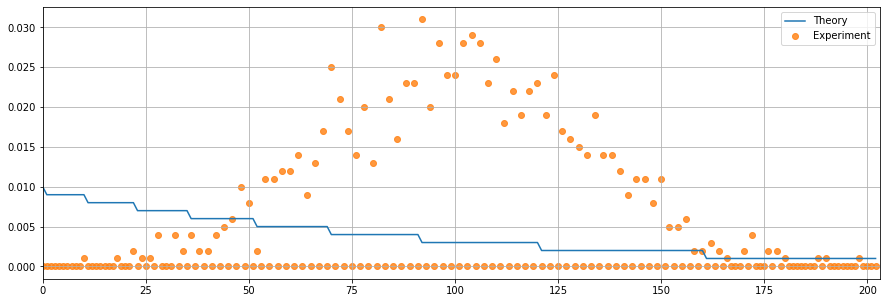

In [12]:
plot_theory_vs_experiment(population, saved_vectors[1])

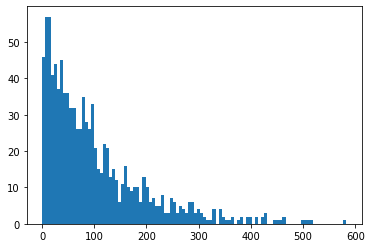

In [9]:
data = show_hist(saved_vectors[-1])

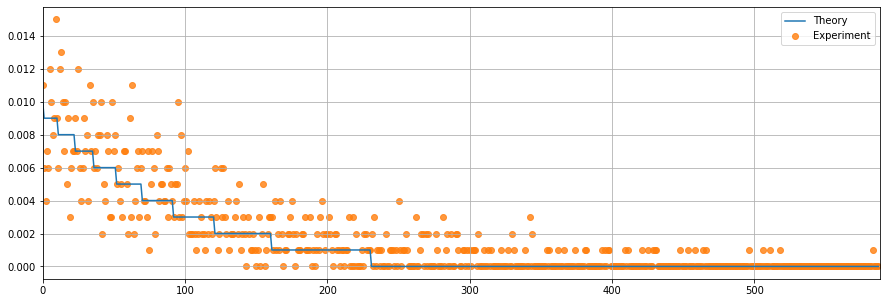

In [13]:
plot_theory_vs_experiment(population, saved_vectors[-1])

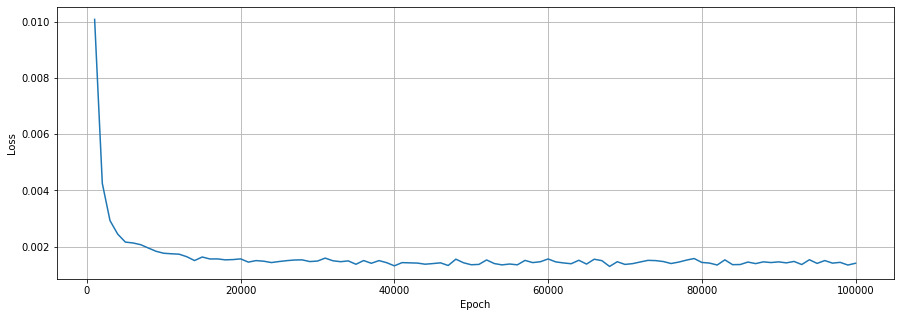

In [10]:
plot_loss_history(saved_losses, epochs_save)

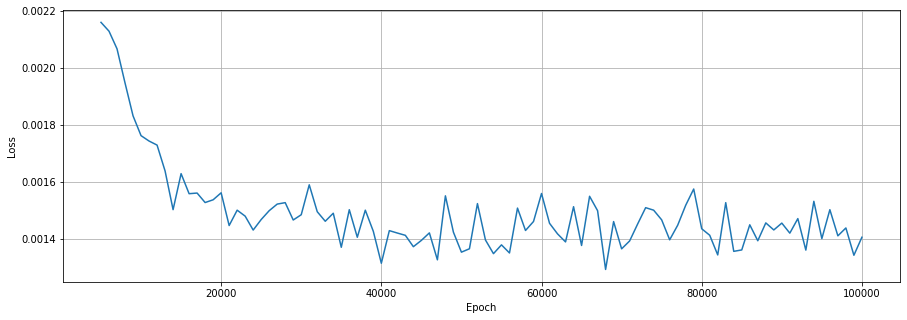

In [11]:
plot_loss_history(saved_losses[5:], epochs_save[5:])

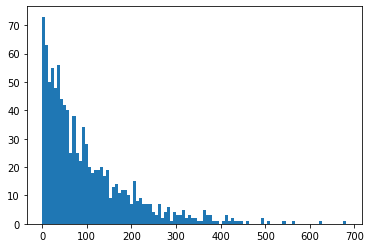

In [15]:
data = show_hist(saved_vectors[95])

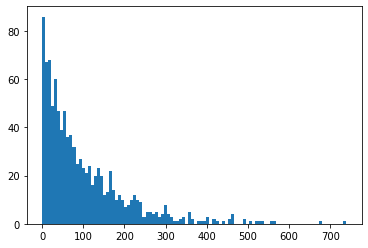

In [17]:
data = show_hist(saved_vectors[90])

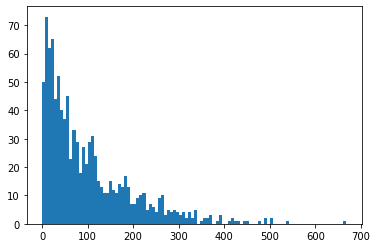

In [16]:
data = show_hist(saved_vectors[50])

## Эксперименты по оценке времени смешивания

Цель данных экспериментов - получение теоретической зависимости времени сходимости экспериментальной зависимости к теоретической. Она пропорциональна натуральному логарифму от числа человек в популяции 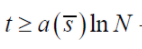  

Прежде всего мы уменьшим интервал логгирования для того, чтобы более точно определить момент сходимости к искомой теоретической зависимости. Также создадим список популяций с разным числом людей. Итерации будем производить с помощью функции patience, которая прекращает итерации как только функция потерь перестала уменьшаться на протяжении указанного числа эпох.  

Таким образом, для каждой популяции мы измерим число итераций до сходимости к экспериментальной зависимости. Ввиду того, что зависимость логарифмическая, нам потребуется как можно более широкий интервал людей в популяциях. Напомню, что ранее были проблемы с требуемым объемом памяти, поэтому число денег у каждого человека ограничено 10 монетами. Это также позволит ускорить сходимость к искомой теоретической кривой

In [266]:
populations = [100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
patience = 20
logging_interval = 20
money_stratification = 10
bet_size = 1
population_list, epochs = train_for_mixing_time(population_list=populations, money_stratification=money_stratification,
                                                patience=patience, logging_interval=logging_interval, bet_size=bet_size)

=========|Starting training with 100 people|=========
20 epochs take 0.026327848434448242 seconds
Epoch:   20. Current loss: 0.06142857
Found new best loss!
Epoch:   40. Current loss: 0.03619047
Found new best loss!
Epoch:   60. Current loss: 0.02269231
Found new best loss!
Epoch:   80. Current loss: 0.02208333
Found new best loss!
Epoch:  100. Current loss: 0.01923077
Found new best loss!
Epoch:  120. Current loss: 0.01703704
Found new best loss!
Epoch:  140. Current loss: 0.01633333
Found new best loss!
Epoch:  160. Current loss: 0.02166667
Epoch:  180. Current loss: 0.01703704
Epoch:  200. Current loss: 0.01785714
Epoch:  220. Current loss: 0.01419355
Found new best loss!
Epoch:  240. Current loss: 0.01451613
Epoch:  260. Current loss: 0.01566667
Epoch:  280. Current loss:    0.013
Found new best loss!
Epoch:  300. Current loss: 0.01357143
Epoch:  320. Current loss: 0.0162069
Epoch:  340. Current loss: 0.01730769
Epoch:  360. Current loss: 0.01258064
Found new best loss!
Epoch:  380

Ожидаемая линейная зависимость в осях графика не проявилась. Возможно мы пропустили точные моменты сходимости из-за того что она была слишком быстрой

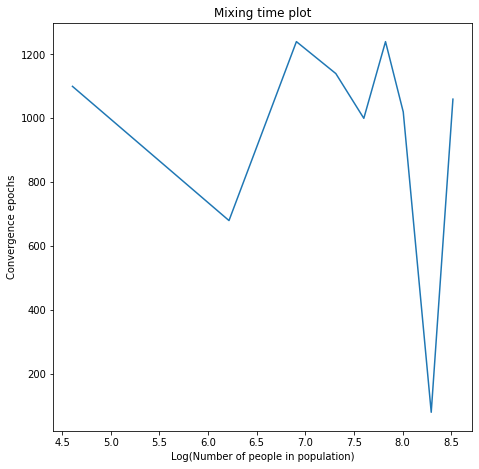

In [285]:
plot_mixing_times(population_list, epochs, log_scale=True)

Попробуем увеличить число денег у каждого человека в популяции. Это замедлит сходимость

In [267]:
populations = [100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
patience = 20
logging_interval = 20
money_stratification = 100
bet_size = 1
population_list_2, epochs_2 = train_for_mixing_time(population_list=populations, money_stratification=money_stratification,
                                                patience=patience, logging_interval=logging_interval, bet_size=bet_size)

=========|Starting training with 100 people|=========
20 epochs take 0.024077177047729492 seconds
Epoch:   20. Current loss: 0.09090908
Found new best loss!
Epoch:   40. Current loss: 0.05882353
Found new best loss!
Epoch:   60. Current loss: 0.05555555
Found new best loss!
Epoch:   80. Current loss:   0.0625
Epoch:  100. Current loss: 0.04761905
Found new best loss!
Epoch:  120. Current loss:     0.04
Found new best loss!
Epoch:  140. Current loss:     0.04
Epoch:  160. Current loss: 0.03571428
Found new best loss!
Epoch:  180. Current loss: 0.03571428
Epoch:  200. Current loss: 0.03225806
Found new best loss!
Epoch:  220. Current loss: 0.03225806
Epoch:  240. Current loss: 0.03571428
Epoch:  260. Current loss: 0.03448276
Epoch:  280. Current loss: 0.03703704
Epoch:  300. Current loss: 0.03448276
Epoch:  320. Current loss:  0.03125
Found new best loss!
Epoch:  340. Current loss:  0.03125
Epoch:  360. Current loss: 0.02941176
Found new best loss!
Epoch:  380. Current loss: 0.02702703
F

Опять искомая зависимость не была обнаружена. Создается впечатление, что сходимость каждой популяции носит случайный характер

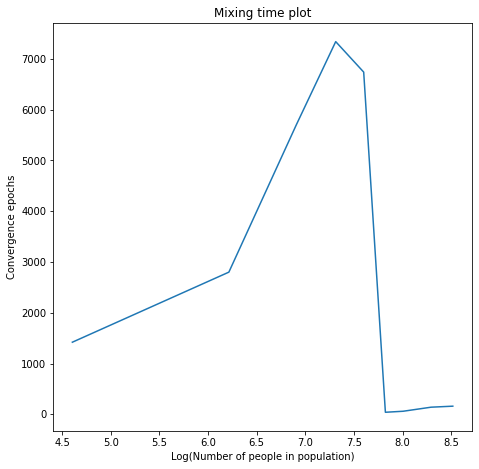

In [284]:
plot_mixing_times(population_list_2, epochs_2, log_scale=True)

Попробуем увеличить время ожидания до сходимости до 50 и уменьшим интервал логгирования до 10

In [6]:
populations = [100, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
patience = 50
logging_interval = 10
money_stratification = 10
bet_size = 1
population_list, epochs = train_for_mixing_time(population_list=populations, money_stratification=money_stratification,
                                                patience=patience, logging_interval=logging_interval, bet_size=bet_size)

=========|Starting training with 100 people|=========
10 epochs take 0.020025968551635742 seconds
Epoch:   10. Current loss:  0.10875
Found new best loss!
Epoch:   20. Current loss: 0.0790909
Found new best loss!
Epoch:   30. Current loss:  0.05875
Found new best loss!
Epoch:   40. Current loss: 0.04157895
Found new best loss!
Epoch:   50. Current loss: 0.03130435
Found new best loss!
Epoch:   60. Current loss: 0.02208333
Found new best loss!
Epoch:   70. Current loss:   0.0204
Found new best loss!
Epoch:   80. Current loss: 0.01814815
Found new best loss!
Epoch:   90. Current loss:     0.02
Epoch:  100. Current loss: 0.01571429
Found new best loss!
Epoch:  110. Current loss: 0.01857143
Epoch:  120. Current loss: 0.01961538
Epoch:  130. Current loss: 0.01258064
Found new best loss!
Epoch:  140. Current loss:    0.015
Epoch:  150. Current loss:   0.0175
Epoch:  160. Current loss: 0.01535714
Epoch:  170. Current loss: 0.01413793
Epoch:  180. Current loss: 0.01961538
Epoch:  190. Current 

И вновь исходная зависимость имеет случайный характер. Отмечу что каждый раз форма зависимости меняется

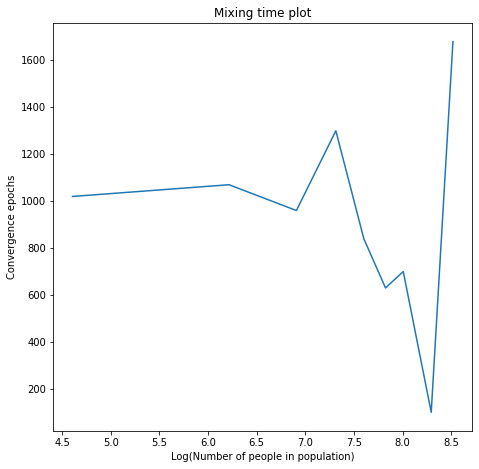

In [9]:
plot_mixing_times(populations, epochs, log_scale=True)

В качестве последнего эксперимента попробуем увеличить размеры популяций до 25000

In [5]:
populations = [100, 500, 1000, 5000, 10000, 25000]
patience = 30
logging_interval = 20
money_stratification = 10
bet_size = 1
population_list, epochs = train_for_mixing_time(population_list=populations, money_stratification=money_stratification,
                                                patience=patience, logging_interval=logging_interval, bet_size=bet_size)

=========|Starting training with 100 people|=========
20 epochs take 0.02615642547607422 seconds
Epoch:   20. Current loss: 0.05928571
Found new best loss!
Epoch:   40. Current loss: 0.02954545
Found new best loss!
Epoch:   60. Current loss:    0.015
Found new best loss!
Epoch:   80. Current loss: 0.01586207
Epoch:  100. Current loss: 0.01193548
Found new best loss!
Epoch:  120. Current loss: 0.01354839
Epoch:  140. Current loss: 0.01433333
Epoch:  160. Current loss: 0.01354839
Epoch:  180. Current loss: 0.01517241
Epoch:  200. Current loss: 0.01333333
Epoch:  220. Current loss: 0.0137931
Epoch:  240. Current loss: 0.01612903
Epoch:  260. Current loss: 0.01481481
Epoch:  280. Current loss: 0.01333333
Epoch:  300. Current loss: 0.01133333
Found new best loss!
Epoch:  320. Current loss:    0.015
Epoch:  340. Current loss: 0.01566667
Epoch:  360. Current loss: 0.01482759
Epoch:  380. Current loss: 0.01482759
Epoch:  400. Current loss: 0.01354839
Epoch:  420. Current loss: 0.01290323
Epoch

KeyboardInterrupt: 

К сожалению и в последний раз не удалось получить ожидаемую зависимость.

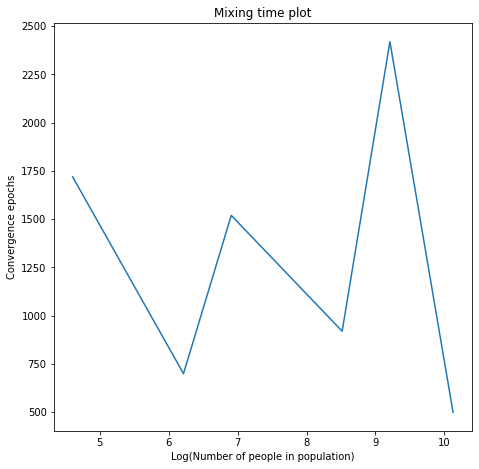

In [11]:
plot_mixing_times(populations, epochs, log_scale=True)

# Результаты работы

В ходе работы написан модуль, позволяющий производить эксперименты с различными вариантами настройки. В ходе 10 экспериментов показаны ожидаемые эффекты от используемых настроек, получены интересные зависимости от входных параметров.  
К сожалению, не удалось получить зависимость числа итераций до сходимости к теоретическому распределению от логарифма числа людей в популяции. Предложенный метод показывает различные зависимости, что, скорее всего связано со случайным характером итераций в популяции.  
В дальнейшем планируется проведение обзора статей по теме социальной кинетики для нахождения правильного способа экспериментальной(или теоретической) оценки числа итераций в популяции до сходимости.